In [29]:
#data loading
import pandas as pd
predata = pd.read_csv(r'C:/Users/BeatrizCarvalho/OneDrive - Closer Consultoria Lda/Documents/Entangled-Spaces/Transfers/Datasets/2transfers_balanced_smote+rund-10m.csv', low_memory = False)

In [30]:
#-------------------------------------------------pre-processing--------------------------------------------------------------#

#convert amount and accountbalance to classes and assign a word to each interval  
import numpy as np

#automatic labels
import string


class LabelCategorizer:
    def __init__(self, base_word='cat'):
        self.initial = 1
        self._alphabet_index = 0
        self.base_word = base_word
        self.current_word = self.base_word
        self.shift = 0

    def __str__(self):
        return 'Class: Label Categorizer\nBase word: ' + self.base_word + '\nCurrent Word: ' + self.current_word

    def get_next_word(self):
        if self.initial:
            self.initial = 0
            return self.current_word

        if self.shift > 0:
            self.current_word = self.current_word[-1] + self.current_word[:-1]
            self.shift -= 1
        else:
            self.current_word = self.current_word + string.ascii_lowercase[self._alphabet_index]
            self._alphabet_index = (self._alphabet_index + 1) % len(string.ascii_lowercase)
            self.shift = len(self.current_word) - 1

        return self.current_word


#replacement of the old columns with the new ones with classes
def cutter(col, number, word, words_map):
    #make sure that only positives are assigned an interval
    col_min = max(predata[col].min(), 1)
    col_max = max(predata[col].max(), 1)

    bins_a = np.geomspace(float(col_min), float(col_max), num=number)
    bins_a[0] = bins_a[0] - 1
    bins_aux = bins_a[1:]
    bins_aux = np.append(bins_aux, bins_a[-1] + 1)
    bin_tuples = list(zip(bins_a, bins_aux))

    bins = pd.IntervalIndex.from_tuples(bin_tuples)

    #range of the intervals made
    labels_a = []

    a = LabelCategorizer(base_word=word)

    for _ in range(number):
        labels_a.append(a.get_next_word())

    x = pd.cut(predata[col].to_list(), bins=bins)
    x.categories = labels_a
    predata[col] = x

    for i in range(number):
        words_map[labels_a[i]] = bins[i]

    #columns to apply the conversion


columns = ['amount', 'accountbalance']

#number of intervals for each column
number_bins = [36, 38]

#base words assigned to each column on columns to apply the conversion
base_words = ['pink', 'red']

#get acess to the range of the interval based on the word that appears
values_map = {}

for i in range(len(columns)):
    cutter(columns[i], number_bins[i], base_words[i], values_map)

In [31]:
#assign the word negaccount for negative values of accountbalance  
aux = predata['accountbalance'].values

vacc = []

for elm in aux:
    if str(elm) == 'nan':
        vacc.append('negaccount')
    else:
        vacc.append(elm)
predata['accountbalance'] = vacc

In [32]:
#convert hours to classes and assign a word to each interval  
bins_hour = [0, 4, 8, 12, 16, 20, 24]

#labels assigned to each interval
labels_hour = ['dawn', 'earlymorning', 'morning', 'afternoon', 'dusk', 'night']

predata['hour'] = list(pd.cut(predata['hour'], bins=bins_hour, labels=labels_hour, retbins=True, include_lowest=True)[0])

In [33]:
#map trusted_indicator values to words
ti_value_map = {
    '0.0': 'ntrusted',
    '0': 'ntrusted',
    '1.0': 'trusted',
    'unknown': 'tunknown'
}

predata['trusted_indicator'] = predata['trusted_indicator'].apply(lambda x: ti_value_map[x])

In [34]:
#add letter before number to distinguish between similar numbers from different columns
cols = ['entity', 'reference', 'iban_orig', 'iban_dest', 'ipaddress', 'clientid', 'week']

identifier = ['e', 'r', 'io', 'id', 'ip', 'c', 'w']

for col in range(len(cols)):
    predata[cols[col]] = predata[cols[col]].apply(lambda x: identifier[col] + str(x))

In [35]:
#convert binary and chains of numbers to specific words
def apply_map(df, col, target_map):
    df[col] = df[col].apply(lambda x: target_map.get(str(x)))


cols_maps = [('is_fraud', {'0': 'nfraud', '1': 'fraud'}),
             ('weekday', {'0': 'mon', '1': 'tue', '2': 'wed', '3': 'thu', '4': 'fri', '5': 'sat', '6': 'sun'}),
             ('month', {'1': 'jan', '2': 'feb', '3': 'mar', '4': 'apr', '5': 'may', '6': 'jun', '7': 'jul', '8': 'aug', 
                        '9': 'sep', '10': 'oct', '11': 'nov', '12': 'dec'})]

for comb in cols_maps:
    apply_map(predata, comb[0], comb[1])

In [36]:
#make fraud column as the center column
new_order = ['canal', 'operativa', 'clientid', 'entity', 'reference', 'trusted_indicator', 'iban_orig', 'iban_dest',
             'amount', 'is_fraud', 'accountbalance', 'ipaddress', 'browser_family', 'os_family', 'hour', 'week', 'weekday',
             'month', 'device']

predata = predata[new_order]

In [37]:
#select data for train and test  
from sklearn.model_selection import train_test_split

#target column
y = predata['is_fraud']
predata.drop('is_fraud', axis=1)

#train and test
X_train, X_test, y_train, y_test = train_test_split(predata, y, stratify=y, test_size=0.3)

In [38]:
#function for conversion format
def convert_to_w2v_format(df):
    sentences = df.to_numpy()
    sentences_aux = [list(curr) for curr in sentences]
    sentences_series = pd.Series(sentences_aux)
    return sentences_series

In [39]:
#for entering the model
sentences_series = convert_to_w2v_format(X_train)

In [40]:
#for the test metrics
X_test_np = X_test.copy()
sentences_series_np_test = convert_to_w2v_format(X_test_np)

In [41]:
#for the train metrics
X_train_np = X_train.copy()
sentences_series_np_train = convert_to_w2v_format(X_train_np)

In [47]:
#-----------------------------------------------------training----------------------------------------------------------------#

#inicialization and training word2vec 
import multiprocessing
from myWord2Vec import MyWord2Vec
from gensim.models.callbacks import CallbackAny2Vec

def training(sentences, window = 1):
    model = MyWord2Vec(
        sg = 1,  #skip-gram 
        workers = multiprocessing.cpu_count(),  #use all cores 
        vector_size = 5,  #dimension of the embedding space 
        window = window,  #words befores and after the center word 
        sample = 0.001,  #whithout subsampling 
        min_count = 1,  #use every word 
        negative = 5,  #noise-words 
        hs = 0,  #negative sampling
        ns_exponent = 0.75,  #exponent to shape negative sampling 
        alpha = 0.035,  #initial learning rate 
        min_alpha = 0.0001,  #final learning rate 
    )

    #vocabulary creation
    model.build_vocab(sentences)

    #model training
    model.train(sentences, epochs = 150, total_examples = model.corpus_count, compute_loss = True, callbacks = [])
    
    return model

In [48]:
#-----------------------------------------------------prediction-------------------------------------------------------------#

#update probv - vector with the parameters of a transaction
from scipy.special import softmax

def predictTransaction(my_model, m_cid, my_curr_cid, verbose):
    #obtain the representative vector of the clientid
    civ = my_model.wv.get_vector(m_cid)

    #multiplication of the clientid vector by the decode matrix (M2)  
    m2 = my_model.syn1neg
    
    #vector of len = vocab_size that softmax is applied to obtain the conditional probabilities 
    vout = softmax(np.dot(civ, m2.T))

    fraud_curr = my_curr_cid.copy()
    fraud_curr.append(my_model.wv.index_to_key.index('fraud'))

    nfraud_curr = my_curr_cid.copy()
    nfraud_curr.append(my_model.wv.index_to_key.index('nfraud'))

    #filter the vector to the transaction fields
    fraud_probv = sum(vout[fraud_curr])
    nfraud_probv = sum(vout[nfraud_curr])

    #print results if verbose True
    if verbose:
        print(f"Transaction: {my_curr_cid}\nFraud prob: {fraud_probv}\nNon Fraud prob: {nfraud_probv}")

    #threshold for false negatives
    # if fraud_probv > threshold: return 1

    if fraud_probv > nfraud_probv:
        return 1, fraud_probv
    
    return 0, nfraud_probv

In [49]:
#prediction method   
def predict(model, X, verbose1, verbose2):
    #save the predictions made by the model in a list
    predictions = []
    predictions_prob = []

    #for each transaction (eval_row)
    for i, eval_row in enumerate(X, 1):

        #print transaction parameters if verbose1 True
        if verbose1:
            print(eval_row)

        #cid is always in position 2 of the array
        curr_cid = eval_row[2]

        #for each sentence_series creates a current list
        curr = []

        #if curr_cid is not known
        if curr_cid not in model.wv.index_to_key:
            #update model
            model.build_vocab([[curr_cid]], update=True)

        #filter the parameters associated with the transaction made by the specific clientid (civ)
        for x in eval_row:
            if x != curr_cid:
                if x in model.wv.index_to_key:
                    curr.append(model.wv.index_to_key.index(x))

                else:
                    #if the word is not known                        
                    #update model
                    model.build_vocab([[x]], update=True)
                    curr.append(model.wv.index_to_key.index(x))

        #sum each value on the array to obtain the final probability
        curr_prediction, curr_prob = predictTransaction(model, curr_cid, curr, verbose2)
        predictions.append(curr_prediction)
        predictions_prob.append(curr_prob)

    return predictions, predictions_prob

In [50]:
#convert true values for the train set to binary
y_train = [1 if elem == "fraud" else 0 for elem in y_train]

In [51]:
#convert true values of the test set to binary
y_test = [1 if elem == "fraud" else 0 for elem in y_test]

In [25]:
#grid-search 
import os
from mlflow import log_metric, log_param, log_artifact
import mlflow
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, matthews_corrcoef, confusion_matrix

#create a hyperparameters dictionary 
dim = [5]  
window = [1]  

#train the model 
i = 0
for d in dim:
    for w in window:
        i+=1
        with mlflow.start_run(nested=True):

            # Log params to mlflow
            log_param("dim", d)
            log_param("window", w)

            curr_model = training(sentences_series_np_train, dim = d, window = w)

            #metrics for each combination - test
            prevs_test = predict(curr_model, sentences_series_np_test[:1000], verbose1 = False, verbose2 = False)
            
            precision_test, recall_test, fscore_test, _ = precision_recall_fscore_support(y_test[:1000], prevs_test, average='micro')
            mcc_test = matthews_corrcoef(y_test[:1000], prevs_test)
            tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_train[:1000], prevs_test, labels = [0, 1]).ravel()
            g_mean = geometric_mean_score(y_test[:1000], prevs_test, average = 'micro')
            
            log_param("accuracy_test", accuracy_score(y_test[:1000], prevs_test))
            log_param("precision_test", precision_test)
            log_param("recall_test", recall_test)
            log_param("f1_test", fscore_test)
            log_param("mcc_test", mcc_test)
            log_param("tn_test", tn_test)
            log_param("fp_test", fp_test)
            log_param("fn_test", fn_test)
            log_param("tp_test", tp_test)
            log_param("g_mean", g_mean)


            curr_model.save("trained_model.w2v")
            log_artifact("trained_model.w2v")
            os.remove("trained_model.w2v")

Validation loss decreased (inf --> 4444024.500000).  Saving model ...
Validation loss decreased (4444024.500000 --> 3232140.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (3232140.500000 --> 2671894.000000).  Saving model ...
Validation loss decreased (2671894.000000 --> 1382794.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
Validation loss decreased (1382794.000000 --> 769008.000000).  Saving model ...
Validation loss decreased (769008.000000 --> 588512.000000).  Saving model ...
Validation loss decreased (588512.000000 --> 585284.000000).  Saving model ...
Validation loss decreased (585284.000000 --> 583868.000000).  Sa

In [57]:
#load the ideal model 
import gensim.models.word2vec as w2v 

model = w2v.Word2Vec.load(r'C:\Users\BeatrizCarvalho\OneDrive - Closer Consultoria Lda\Documents\Entangled-Spaces\Transfers\Notebooks\After loss correction\transfers-1M\trained_model.w2v') 

In [63]:
#call predictions
prevs, prevs_prob = predict(curr_model, sentences_series_np_test, verbose1 = True, verbose2 = True)

['nbe', 'trfitc', 'c986326', 'e3', 'r3', 'ntrusted', 'io316192', 'id16549982', 'cndkapbi', 'nfraud', 'daerbecd', 'ip622813172', 'edge', 'windows', 'morning', 'w17', 'fri', 'apr', 'pc']
Transaction: [12, 167, 0, 1, 2, 5049, 1631536, 79, 9, 273, 3830, 72, 4, 6, 57, 31, 21, 3]
Fraud prob: 0.00023857190740921106
Non Fraud prob: 0.0002386066665487777
['nbe', 'trfips', 'c1217880', 'e3', 'r3', 'ntrusted', 'io1104771', 'id14378556', 'bicndkap', 'fraud', 'rbecddae', 'ip8524220641', 'chrome', 'windows', 'dusk', 'w19', 'mon', 'may', 'pc']
Transaction: [12, 16, 0, 1, 2, 1631538, 86, 272, 8, 96, 99, 5, 4, 22, 14, 10, 13, 3]
Fraud prob: 1.4396819977946507e-05
Non Fraud prob: 1.4386160756885147e-05
['nbe', 'trfsep', 'c1227163', 'e3', 'r3', 'trusted', 'io1227164', 'id1970254', 'kapbicn', 'nfraud', 'erbecdda', 'ip775418363', 'chrome', 'windows', 'morning', 'w19', 'fri', 'may', 'pc']
Transaction: [12, 7, 0, 1, 17, 53853, 231075, 36, 9, 169, 1631539, 5, 4, 6, 14, 31, 13, 3]
Fraud prob: 0.0001493275381795

Transaction: [11, 15, 0, 1, 17, 1631575, 1631576, 69, 9, 78, 1631577, 51, 4, 22, 230, 26, 81, 3]
Fraud prob: 1.2711452029634529e-05
Non Fraud prob: 1.2710616459798985e-05
['mbp', 'trfint', 'c4647515', 'e3', 'r3', 'ntrusted', 'io507245', 'id3245932', 'nkapbi', 'nfraud', 'cddarbe', 'ip79168244103', 'other', 'android', 'afternoon', 'w52', 'mon', 'dec', 'ttablet']
Transaction: [18, 15, 0, 1, 2, 165419, 1631579, 48, 9, 49, 342102, 29, 19, 20, 77, 10, 39, 28]
Fraud prob: 1.1593582570412764e-05
Non Fraud prob: 1.1590264847427534e-05
['nbp', 'trfsep', 'c5002011', 'e3', 'r3', 'ntrusted', 'io5002012', 'id5756902', 'binkap', 'nfraud', 'darbecd', 'ip85245142150', 'chrome', 'windows', 'night', 'w41', 'thu', 'oct', 'pc']
Transaction: [11, 7, 0, 1, 2, 1631580, 1631581, 69, 9, 41, 1631582, 5, 4, 40, 124, 25, 58, 3]
Fraud prob: 4.622998295822356e-05
Non Fraud prob: 4.6163208141436485e-05
['nbp', 'trfips', 'c4854028', 'e3', 'r3', 'ntrusted', 'io4854029', 'id11612647', 'kapbicnd', 'fraud', 'ecddarb', 'ip

Transaction: [18, 7, 0, 1, 2, 1631627, 1631628, 45, 9, 23, 667902, 30, 33, 20, 80, 31, 32, 24]
Fraud prob: 1.3658041353892258e-05
Non Fraud prob: 1.3657815799206219e-05
['nbp', 'trfips', 'c4854028', 'e3', 'r3', 'ntrusted', 'io4854029', 'id11612647', 'kapbicn', 'fraud', 'ecddarb', 'ip1682322070', 'chrome', 'windows', 'afternoon', 'w4', 'mon', 'jan', 'pc']
Transaction: [11, 16, 0, 1, 2, 163, 165, 36, 8, 67, 122, 5, 4, 20, 64, 10, 32, 3]
Fraud prob: 1.3854638689835718e-05
Non Fraud prob: 1.3854652493910788e-05
['nbp', 'trfsep', 'c5047003', 'e3', 'r3', 'ntrusted', 'io918830', 'id5313005', 'apbink', 'nfraud', 'arbecd', 'ip19312683109', 'chrome', 'windows', 'afternoon', 'w48', 'tue', 'nov', 'pc']
Transaction: [11, 7, 0, 1, 2, 1631630, 1631631, 61, 9, 34, 10348, 5, 4, 20, 109, 26, 60, 3]
Fraud prob: 1.2919198326244441e-05
Non Fraud prob: 1.2903701446020932e-05
['mbp', 'trfsep', 'c3302051', 'e3', 'r3', 'ntrusted', 'io3302052', 'id3302053', 'kapbin', 'nfraud', 'becdar', 'ip82252135178', 'other'

Transaction: [12, 7, 0, 1, 2, 1631663, 1631664, 44, 8, 35, 1631665, 5, 4, 6, 14, 10, 32, 3]
Fraud prob: 1.1560149459910463e-05
Non Fraud prob: 1.1517047141751391e-05
['nbe', 'trfsep', 'c1508857', 'e3', 'r3', 'ntrusted', 'io1508858', 'id3503911', 'bicnkap', 'fraud', 'aerbecdd', 'ip622821682', 'chrome', 'windows', 'morning', 'w9', 'thu', 'feb', 'pc']
Transaction: [12, 7, 0, 1, 2, 211, 212, 54, 8, 226, 209, 5, 4, 6, 95, 25, 46, 3]
Fraud prob: 0.0024029416293895817
Non Fraud prob: 0.0024029111147978394
['nbp', 'trfint', 'c4458016', 'e3', 'r3', 'ntrusted', 'io4458018', 'id1193702', 'kapbin', 'nfraud', 'darbecd', 'ip18882116139', 'safari', 'ios', 'dusk', 'w47', 'sun', 'nov', 'tmobile']
Transaction: [11, 15, 0, 1, 2, 1631667, 1631668, 63, 9, 41, 1631669, 30, 33, 22, 130, 71, 60, 24]
Fraud prob: 1.2172406286481419e-05
Non Fraud prob: 1.2168163209480554e-05
['nbe', 'trfsep', 'c1640976', 'e3', 'r3', 'trusted', 'io1550881', 'id656471', 'cnkapbi', 'nfraud', 'ecddarb', 'ip891154765', 'chrome', 'win

Transaction: [11, 7, 0, 1, 2, 1631705, 1631706, 42, 9, 34, 1179964, 29, 4, 22, 129, 31, 60, 187]
Fraud prob: 1.3492650111857074e-05
Non Fraud prob: 1.3487077524132474e-05
['nbp', 'trfips', 'c4261615', 'e3', 'r3', 'ntrusted', 'io1115238', 'id12350471', 'cndkapbi', 'fraud', 'cddarbe', 'ip843572729', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 16, 0, 1, 2, 1631708, 1631709, 79, 8, 49, 1631710, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.1088184777463539e-05
Non Fraud prob: 1.1109796332675614e-05
['mbp', 'trfsep', 'c3732576', 'e3', 'r3', 'trusted', 'io1487994', 'id2982117', 'nkapbi', 'nfraud', 'negaccount', 'ip8524713691', 'other', 'android', 'morning', 'w38', 'mon', 'sep', 'ttablet']
Transaction: [18, 7, 0, 1, 17, 1524837, 1631712, 48, 9, 23, 1524839, 29, 19, 6, 146, 10, 55, 28]
Fraud prob: 1.5734137605249998e-05
Non Fraud prob: 1.5738804194143086e-05
['nbp', 'trfsep', 'c3309305', 'e3', 'r3', 'ntrusted', 'io1914268', 'id2561610', 'dkapbicn', 'fraud', 'darbecd', 

Transaction: [12, 7, 0, 1, 2, 1631762, 1631763, 70, 8, 73, 1631764, 5, 4, 6, 14, 31, 13, 3]
Fraud prob: 1.6834317563052537e-05
Non Fraud prob: 1.684610825236632e-05
['nbp', 'trfint', 'c3818818', 'e3', 'r3', 'trusted', 'io269488', 'id971772', 'pbicnka', 'nfraud', 'arbecdd', 'ip8524713824', 'firefox', 'windows', 'morning', 'w14', 'tue', 'mar', 'pc']
Transaction: [11, 15, 0, 1, 17, 1631766, 1631767, 42, 9, 35, 1631768, 51, 4, 6, 94, 26, 53, 3]
Fraud prob: 1.1212185356157534e-05
Non Fraud prob: 1.1222321617765374e-05
['nbp', 'trfsep', 'c3951257', 'e3', 'r3', 'ntrusted', 'io4907237', 'id15264469', 'cndkapbi', 'fraud', 'rbecdda', 'ip1742042231', 'firefox', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 7, 0, 1, 2, 1631770, 1631771, 79, 8, 73, 1631772, 51, 4, 6, 14, 10, 13, 3]
Fraud prob: 9.73144568661155e-06
Non Fraud prob: 9.759335341641417e-06
['nbe', 'trfsep', 'c3797869', 'e3', 'r3', 'ntrusted', 'io310814', 'id731384', 'bicnkap', 'fraud', 'rbecddae', 'ip658309480', 'ch

Transaction: [11, 15, 0, 1, 17, 1631810, 1631811, 63, 9, 35, 1631812, 5, 4, 20, 156, 10, 53, 3]
Fraud prob: 0.00013100522051168184
Non Fraud prob: 0.0001309734882699587
['nbp', 'trfsep', 'c7286045', 'e3', 'r3', 'ntrusted', 'io6927141', 'id7286046', 'bicnkap', 'fraud', 'becdar', 'ip188250170215', 'chrome', 'android', 'morning', 'w19', 'mon', 'mar', 'tmobile']
Transaction: [11, 7, 0, 1, 2, 142, 140, 54, 8, 43, 143, 5, 19, 6, 14, 10, 53, 24]
Fraud prob: 0.0003561120681568173
Non Fraud prob: 0.00035611210729982555
['mbp', 'trfint', 'c2213089', 'e3', 'r3', 'ntrusted', 'io2213091', 'id9128548', 'nkapbi', 'nfraud', 'negaccount', 'ip8719672129', 'other', 'android', 'afternoon', 'w21', 'tue', 'may', 'ttablet']
Transaction: [18, 15, 0, 1, 2, 1631814, 1631815, 48, 9, 23, 3061, 29, 19, 20, 87, 26, 13, 28]
Fraud prob: 1.0354213785035427e-05
Non Fraud prob: 1.0323502536380147e-05
['nbe', 'trfint', 'c776529', 'e3', 'r3', 'trusted', 'io12199', 'id674946', 'inkapb', 'nfraud', 'rbecddae', 'ip17679146104

Transaction: [11, 16, 0, 1, 2, 223113, 1631850, 66, 9, 169, 48609, 30, 33, 22, 95, 26, 46, 24]
Fraud prob: 8.732810364203702e-05
Non Fraud prob: 8.731111206411457e-05
['nbp', 'trfsep', 'c10127964', 'e3', 'r3', 'ntrusted', 'io1971004', 'id16362171', 'icnkapb', 'fraud', 'rbecda', 'ip105138104117', 'chrome', 'android', 'morning', 'w17', 'mon', 'apr', 'tmobile']
Transaction: [11, 7, 0, 1, 2, 1631852, 1631853, 47, 8, 38, 120, 5, 19, 6, 57, 10, 21, 24]
Fraud prob: 1.3664690982295724e-05
Non Fraud prob: 1.3679545133982174e-05
['mbp', 'trfint', 'c17944796', 'e3', 'r3', 'ntrusted', 'io2341315', 'id2341316', 'nkapbi', 'nfraud', 'negaccount', 'ip1486913234', 'safari', 'ios', 'dusk', 'w21', 'sat', 'may', 'tmobile']
Transaction: [18, 15, 0, 1, 2, 742491, 742492, 48, 9, 23, 1241774, 30, 33, 22, 87, 68, 13, 24]
Fraud prob: 1.5320610572189253e-05
Non Fraud prob: 1.5307370489381356e-05
['nbe', 'trfint', 'c5031113', 'e3', 'r3', 'ntrusted', 'io539172', 'id778318', 'pbicnka', 'fraud', 'arbecdd', 'ip471841

Transaction: [11, 7, 0, 1, 2, 1631885, 1631886, 61, 9, 78, 1631887, 72, 4, 40, 14, 25, 13, 3]
Fraud prob: 1.02278915505849e-05
Non Fraud prob: 1.0236980131139717e-05
['nbe', 'trfips', 'c920269', 'e3', 'r3', 'ntrusted', 'io920270', 'id12618093', 'cndkapbi', 'fraud', 'ecddarb', 'ip8524376705', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [12, 16, 0, 1, 2, 1631889, 1631890, 79, 8, 67, 1631891, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.5173756310105091e-05
Non Fraud prob: 1.5138361305844228e-05
['nbe', 'trfint', 'c1488323', 'e3', 'r3', 'ntrusted', 'io896391', 'id1689575', 'apbicnk', 'nfraud', 'erbecdda', 'ip148693553', 'safari', 'ios', 'morning', 'w1', 'mon', 'dec', 'tmobile']
Transaction: [12, 15, 0, 1, 2, 8746, 489485, 50, 9, 169, 167241, 30, 33, 6, 118, 10, 39, 24]
Fraud prob: 0.0002540642912298029
Non Fraud prob: 0.0002540807323644788
['nbp', 'trfint', 'c3268258', 'e3', 'r3', 'trusted', 'io630200', 'id227650', 'cnkapbi', 'nfraud', 'arbecd', 'ip1486323376', 'chrom

Transaction: [11, 7, 0, 1, 2, 1631932, 1631933, 69, 9, 84, 1631934, 5, 4, 40, 126, 10, 55, 3]
Fraud prob: 1.4002991321149239e-05
Non Fraud prob: 1.3997559022982387e-05
['nbe', 'trfsep', 'c1086155', 'e3', 'r3', 'trusted', 'io1086156', 'id2340270', 'pbicnka', 'nfraud', 'darbecd', 'ip89153215169', 'chrome', 'windows', 'afternoon', 'w46', 'thu', 'nov', 'pc']
Transaction: [12, 7, 0, 1, 17, 180829, 683235, 42, 9, 41, 180830, 5, 4, 20, 129, 25, 60, 3]
Fraud prob: 0.00013220671619618152
Non Fraud prob: 0.00013219403434416854
['nbe', 'trfips', 'c1284883', 'e3', 'r3', 'ntrusted', 'io1284884', 'id14378556', 'cndkapbi', 'fraud', 'ecddarb', 'ip8524220641', 'chrome', 'windows', 'morning', 'w18', 'thu', 'apr', 'pc']
Transaction: [12, 16, 0, 1, 2, 150, 86, 79, 8, 67, 99, 5, 4, 6, 62, 25, 21, 3]
Fraud prob: 0.004401197469417638
Non Fraud prob: 0.004401183705908195
['nbe', 'trfsep', 'c2321634', 'e3', 'r3', 'ntrusted', 'io1133879', 'id2549606', 'cnkapbi', 'fraud', 'becddar', 'ip785624354', 'edge', 'windo

Transaction: [11, 7, 0, 1, 2, 1631976, 1477477, 47, 9, 52, 1631977, 51, 4, 40, 153, 68, 81, 3]
Fraud prob: 1.2804391730014686e-05
Non Fraud prob: 1.278760336731466e-05
['nbp', 'trfsep', 'c7010858', 'e3', 'r3', 'ntrusted', 'io5222782', 'id11650497', 'apbicnk', 'fraud', 'arbecd', 'ip13899210102', 'chrome', 'windows', 'morning', 'w4', 'tue', 'jan', 'pc']
Transaction: [11, 7, 0, 1, 2, 1631979, 318, 50, 8, 34, 260, 5, 4, 6, 64, 26, 32, 3]
Fraud prob: 1.3200735708096545e-05
Non Fraud prob: 1.3194957688256181e-05
['nbp', 'trfips', 'c13681089', 'e3', 'r3', 'ntrusted', 'io13681091', 'id16683785', 'ndkapbic', 'fraud', 'ddarbec', 'ip79771837509', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 16, 0, 1, 2, 1631981, 70114, 70, 8, 52, 1631982, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 9.317805279351887e-06
Non Fraud prob: 9.355977908853674e-06
['nbe', 'trfsep', 'c1307919', 'e3', 'r3', 'trusted', 'io1307920', 'id1208886', 'icnkapb', 'nfraud', 'becdar', 'ip3728235236', 'chrome'

Transaction: [12, 15, 0, 1, 17, 1632017, 30425, 155, 9, 41, 1767, 51, 4, 6, 123, 25, 46, 3]
Fraud prob: 1.214281672901052e-05
Non Fraud prob: 1.2144204674768844e-05
['nbp', 'trfint', 'c3742543', 'e3', 'r3', 'ntrusted', 'io1354803', 'id862748', 'nkapbic', 'nfraud', 'cddarbe', 'ip18882184172', 'edge', 'windows', 'dusk', 'w21', 'thu', 'may', 'pc']
Transaction: [11, 15, 0, 1, 2, 1632019, 1632020, 45, 9, 49, 1632021, 72, 4, 22, 87, 25, 13, 3]
Fraud prob: 1.3263603705127025e-05
Non Fraud prob: 1.3257562443413917e-05
['nbp', 'trfsep', 'c3659183', 'e3', 'r3', 'ntrusted', 'io7063052', 'id8071206', 'ndkapbic', 'fraud', 'ddarbec', 'ip89155118409', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 7, 0, 1, 2, 573172, 1632023, 70, 8, 52, 1632024, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.4115378235146636e-05
Non Fraud prob: 1.4100266014338558e-05
['nbe', 'trfsep', 'c2285589', 'e3', 'r3', 'ntrusted', 'io75352', 'id11518369', 'apbicnk', 'nfraud', 'rbecddae', 'ip622812598', 'chr

Transaction: [11, 7, 0, 1, 17, 1632055, 1632056, 63, 9, 49, 5769, 5, 4, 6, 153, 25, 81, 3]
Fraud prob: 1.3079268882165707e-05
Non Fraud prob: 1.3084921391737225e-05
['nbe', 'trfsep', 'c2898298', 'e3', 'r3', 'ntrusted', 'io283240', 'id2679670', 'kapbicnd', 'fraud', 'rbecddae', 'ip3964833', 'safari', 'ios', 'morning', 'w19', 'mon', 'may', 'tmobile']
Transaction: [12, 7, 0, 1, 2, 1632058, 1632059, 44, 8, 96, 1632060, 30, 33, 6, 14, 10, 13, 24]
Fraud prob: 1.306973123860189e-05
Non Fraud prob: 1.3059911651680522e-05
['mbp', 'trfint', 'c17173787', 'e3', 'r3', 'ntrusted', 'io13809081', 'id555542', 'nkapbic', 'fraud', 'negaccount', 'ip1882511290', 'other', 'android', 'morning', 'w20', 'tue', 'may', 'ttablet']
Transaction: [18, 15, 0, 1, 2, 184, 183, 45, 8, 23, 174, 29, 19, 6, 76, 26, 13, 28]
Fraud prob: 0.00019426269640253734
Non Fraud prob: 0.00019426260475939982
['mbe', 'trfips', 'c844188', 'e3', 'r3', 'ntrusted', 'io844189', 'id1096789', 'cnkapbi', 'nfraud', 'becddar', 'ipunknown', 'other'

Transaction: [12, 16, 0, 1, 2, 1632098, 1632099, 115, 8, 67, 1632100, 5, 4, 6, 14, 31, 13, 3]
Fraud prob: 1.745393205965229e-05
Non Fraud prob: 1.7453966506764118e-05
['nbp', 'trfsep', 'c16127221', 'e3', 'r3', 'ntrusted', 'io16127224', 'id16401007', 'kapbicnd', 'fraud', 'ecddarb', 'ip105138104117', 'chrome', 'android', 'morning', 'w17', 'thu', 'apr', 'tmobile']
Transaction: [11, 7, 0, 1, 2, 1632102, 558695, 44, 8, 67, 120, 5, 19, 6, 57, 25, 21, 24]
Fraud prob: 1.6145903146025375e-05
Non Fraud prob: 1.6144330743372848e-05
['mbp', 'trfint', 'c8322579', 'e3', 'r3', 'ntrusted', 'io8322580', 'id8322581', 'kapin', 'nfraud', 'negaccount', 'ip83223224128', 'safari', 'ios', 'afternoon', 'w8', 'wed', 'feb', 'tmobile']
Transaction: [18, 15, 0, 1, 2, 1632104, 1632105, 155, 9, 23, 1632106, 30, 33, 20, 135, 27, 46, 24]
Fraud prob: 1.869274450427838e-05
Non Fraud prob: 1.867030030666683e-05
['nbe', 'trfsep', 'c2416376', 'e3', 'r3', 'ntrusted', 'io6785332', 'id4966788', 'kapbin', 'nfraud', 'daerbecd',

Transaction: [18, 15, 0, 1, 2, 1632145, 1632146, 50, 9, 23, 1632147, 29, 19, 83, 97, 25, 53, 28]
Fraud prob: 1.9625382662979973e-05
Non Fraud prob: 1.9636200079276023e-05
['mbp', 'trfint', 'c2046404', 'e3', 'r3', 'ntrusted', 'io13630682', 'id2046406', 'binkap', 'nfraud', 'negaccount', 'ip312216260', 'other', 'android', 'morning', 'w9', 'fri', 'feb', 'ttablet']
Transaction: [18, 15, 0, 1, 2, 1632149, 950834, 69, 9, 23, 79396, 29, 19, 6, 95, 31, 46, 28]
Fraud prob: 1.1528534116678202e-05
Non Fraud prob: 1.1526776006576256e-05
['nbe', 'trfsep', 'c1102591', 'e3', 'r3', 'trusted', 'io768304', 'id12681', 'bicnkap', 'nfraud', 'daerbecd', 'ip1888058167', 'chrome', 'windows', 'afternoon', 'w46', 'mon', 'nov', 'pc']
Transaction: [12, 7, 0, 1, 17, 99685, 1401, 54, 9, 273, 1576, 5, 4, 20, 129, 10, 60, 3]
Fraud prob: 7.255905278552577e-05
Non Fraud prob: 7.260001946801653e-05
['nbp', 'trfint', 'c4417558', 'e3', 'r3', 'ntrusted', 'io4884697', 'id792480', 'kapbicn', 'nfraud', 'arbecdd', 'ip19479869',

Transaction: [12, 7, 0, 1, 2, 1632180, 1632181, 115, 8, 84, 1632182, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.2224003029359665e-05
Non Fraud prob: 1.2243945803902534e-05
['nbe', 'trfips', 'c5132935', 'e3', 'r3', 'ntrusted', 'io2633182', 'id7312460', 'kapbicnd', 'fraud', 'darbecd', 'ip1389921045', 'chrome', 'windows', 'morning', 'w4', 'wed', 'jan', 'pc']
Transaction: [12, 16, 0, 1, 2, 1632184, 302, 44, 8, 41, 305, 5, 4, 6, 64, 27, 32, 3]
Fraud prob: 1.4511029874597625e-05
Non Fraud prob: 1.449653176166521e-05
['nbp', 'trfips', 'c5427156', 'e3', 'r3', 'ntrusted', 'io3936937', 'id11495699', 'ndkapbic', 'fraud', 'ddarbec', 'ip18794684474', 'chrome', 'windows', 'morning', 'w19', 'mon', 'jan', 'pc']
Transaction: [11, 16, 0, 1, 2, 1632186, 1632187, 70, 8, 52, 1632188, 5, 4, 6, 14, 10, 32, 3]
Fraud prob: 1.6509958101096345e-05
Non Fraud prob: 1.6506147375139335e-05
['nbp', 'trfsep', 'c3291838', 'e3', 'r3', 'ntrusted', 'io281792', 'id18404081', 'kapbicnd', 'fraud', 'arbecdd', 'ip10949186125', 'chr

Transaction: [11, 7, 0, 1, 2, 1632236, 1632237, 37, 8, 41, 1632238, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.1872343776531125e-05
Non Fraud prob: 1.1866379935554505e-05
['mbp', 'trfint', 'c4006659', 'e3', 'r3', 'ntrusted', 'io4006661', 'id9413286', 'icnkapb', 'nfraud', 'rbecda', 'ip9460160173', 'other', 'android', 'night', 'w50', 'mon', 'dec', 'ttablet']
Transaction: [18, 15, 0, 1, 2, 1632240, 1632241, 47, 9, 38, 1632242, 29, 19, 40, 117, 10, 39, 28]
Fraud prob: 1.0553650682254556e-05
Non Fraud prob: 1.0556170437325818e-05
['nbp', 'trfint', 'c3129372', 'e3', 'r3', 'trusted', 'io1165811', 'id1566227', 'kapbin', 'nfraud', 'ecdarb', 'ip7916925249', 'safari', 'macosx', 'morning', 'w37', 'tue', 'sep', 'pc']
Transaction: [11, 15, 0, 1, 17, 365805, 177472, 63, 9, 59, 54131, 30, 75, 6, 82, 26, 55, 3]
Fraud prob: 0.00011127602153965244
Non Fraud prob: 0.00011125868424005647
['nbp', 'trfint', 'c507956', 'e3', 'r3', 'trusted', 'io507957', 'id507958', 'apbink', 'nfraud', 'darbecd', 'ip6228182118', 'c

Transaction: [11, 7, 0, 1, 2, 1632279, 1632280, 42, 8, 67, 225, 5, 4, 6, 80, 27, 32, 3]
Fraud prob: 1.4505528412200874e-05
Non Fraud prob: 1.4463164433209386e-05
['nbe', 'trfsep', 'c7806865', 'e3', 'r3', 'ntrusted', 'io1262738', 'id13937839', 'apbicnk', 'nfraud', 'cddaerbe', 'ip6228937', 'chrome', 'windows', 'morning', 'w10', 'wed', 'mar', 'pc']
Transaction: [12, 7, 0, 1, 2, 34173, 1632281, 50, 9, 343, 19451, 5, 4, 6, 156, 27, 53, 3]
Fraud prob: 6.574329994951666e-05
Non Fraud prob: 6.577698962279e-05
['nbe', 'trfsep', 'c2732137', 'e3', 'r3', 'ntrusted', 'io2732139', 'id12252962', 'kapbin', 'fraud', 'rbecda', 'ip8718863379', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [12, 7, 0, 1, 2, 1465501, 1632283, 63, 8, 38, 1632284, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.4704184792435626e-05
Non Fraud prob: 1.4682490785844493e-05
['mbp', 'trfsep', 'c8364921', 'e3', 'r3', 'ntrusted', 'io517601', 'id4073096', 'kapbin', 'nfraud', 'negaccount', 'ip8322323269', 'other', 'and

Transaction: [18, 15, 0, 1, 2, 1632326, 1407119, 50, 9, 49, 30804, 30, 33, 22, 77, 25, 39, 24]
Fraud prob: 5.240510198695203e-05
Non Fraud prob: 5.230236248116027e-05
['nbe', 'trfsep', 'c15215992', 'e3', 'r3', 'ntrusted', 'io15215993', 'id14383064', 'dkapbicn', 'fraud', 'darbecd', 'ip959336172', 'chrome', 'windows', 'morning', 'w19', 'mon', 'apr', 'pc']
Transaction: [12, 7, 0, 1, 2, 158, 1632327, 37, 8, 41, 160, 5, 4, 6, 14, 10, 21, 3]
Fraud prob: 0.0015803104344597572
Non Fraud prob: 0.0015802952706499937
['nbe', 'trfsep', 'c2492189', 'e3', 'r3', 'ntrusted', 'io964574', 'id1257586', 'cndkapbi', 'fraud', 'becddar', 'ip638386602', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [12, 7, 0, 1, 2, 1632329, 1632330, 79, 8, 74, 1632331, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.4576174663716301e-05
Non Fraud prob: 1.4540911053018135e-05
['nbe', 'trfsep', 'c1632911', 'e3', 'r3', 'trusted', 'io1632912', 'id659331', 'nkapbic', 'nfraud', 'arbecd', 'ip52493465', 'chrome', 'win

Transaction: [11, 15, 0, 1, 17, 1632368, 1632369, 47, 9, 49, 1311023, 51, 4, 40, 82, 31, 55, 3]
Fraud prob: 1.1248597985513697e-05
Non Fraud prob: 1.1248024321730554e-05
['nbp', 'trfint', 'c3609510', 'e3', 'r3', 'trusted', 'io328654', 'id3082430', 'cnkapbi', 'nfraud', 'arbecdd', 'ip89181238253', 'chrome', 'windows', 'dawn', 'w51', 'sat', 'dec', 'pc']
Transaction: [11, 15, 0, 1, 17, 1632371, 1632372, 56, 9, 35, 1632373, 5, 4, 85, 107, 68, 39, 3]
Fraud prob: 1.879544106486719e-05
Non Fraud prob: 1.879072374322277e-05
['nbe', 'trfint', 'c441766', 'e3', 'r3', 'ntrusted', 'io847447', 'id1177554', 'apbicnk', 'nfraud', 'erbecdda', 'ip18825037171', 'chrome', 'windows', 'morning', 'w7', 'thu', 'feb', 'pc']
Transaction: [12, 15, 0, 1, 2, 22065, 819937, 50, 9, 169, 794280, 5, 4, 6, 123, 25, 46, 3]
Fraud prob: 0.00011396733914706761
Non Fraud prob: 0.00011399821382765754
['nbp', 'trfips', 'c7998136', 'e3', 'r3', 'ntrusted', 'io7998138', 'id15789100', 'ndkapbic', 'fraud', 'ecddarb', 'ip80172235158'

Transaction: [11, 7, 0, 1, 2, 1632406, 1632407, 69, 9, 38, 1632408, 5, 4, 6, 57, 10, 21, 3]
Fraud prob: 9.690105898130241e-06
Non Fraud prob: 9.718140333347947e-06
['mbp', 'trfint', 'c2364528', 'e3', 'r3', 'ntrusted', 'io1790928', 'id1790929', 'cnkapbi', 'nfraud', 'rbecda', 'ip148691277', 'safari', 'ios', 'dusk', 'w39', 'fri', 'sep', 'tmobile']
Transaction: [18, 15, 0, 1, 2, 1632409, 1632410, 56, 9, 38, 704951, 30, 33, 22, 126, 31, 55, 24]
Fraud prob: 5.8382120187258635e-05
Non Fraud prob: 5.833013958077282e-05
['mbp', 'trfsep', 'c3175987', 'e3', 'r3', 'ntrusted', 'io2125778', 'id15530324', 'inkapb', 'nfraud', 'negaccount', 'ip95172176230', 'other', 'android', 'night', 'w15', 'mon', 'apr', 'ttablet']
Transaction: [18, 7, 0, 1, 2, 591834, 1632411, 100, 9, 23, 591829, 29, 19, 40, 106, 10, 21, 28]
Fraud prob: 6.848476620269217e-05
Non Fraud prob: 6.837158117867226e-05
['nbe', 'trfips', 'c1069325', 'e3', 'r3', 'ntrusted', 'io854373', 'id15929661', 'cndkapbi', 'fraud', 'cddarbe', 'ip8524124

Transaction: [18, 15, 0, 1, 2, 1389094, 1389095, 50, 9, 23, 997637, 29, 19, 22, 156, 10, 53, 28]
Fraud prob: 6.34235952025608e-05
Non Fraud prob: 6.335448585498282e-05
['nbe', 'trfsep', 'c1141516', 'e3', 'r3', 'trusted', 'io873014', 'id2476259', 'pbicnka', 'nfraud', 'arbecd', 'ip8423208145', 'chrome', 'windows', 'dusk', 'w36', 'tue', 'sep', 'pc']
Transaction: [12, 7, 0, 1, 17, 4002, 1632440, 42, 9, 34, 39228, 5, 4, 22, 121, 26, 55, 3]
Fraud prob: 0.00021254513268806146
Non Fraud prob: 0.00021257916498504197
['mbp', 'trfint', 'c1951944', 'e3', 'r3', 'ntrusted', 'io1951946', 'id3199584', 'pbinka', 'nfraud', 'rbecda', 'ip85240158130', 'safari', 'ios', 'dawn', 'w48', 'sun', 'dec', 'tmobile']
Transaction: [18, 15, 0, 1, 2, 268582, 268584, 66, 9, 38, 268587, 30, 33, 85, 109, 71, 39, 24]
Fraud prob: 7.825110748516106e-05
Non Fraud prob: 7.818234474032959e-05
['nbe', 'trfsep', 'c1456690', 'e3', 'r3', 'ntrusted', 'io890290', 'id4061362', 'dkapbicn', 'fraud', 'daerbecd', 'ip6498506473', 'chrome'

Transaction: [18, 7, 0, 1, 2, 1632492, 205393, 47, 9, 23, 1632493, 30, 33, 20, 114, 25, 32, 24]
Fraud prob: 1.3986858419912096e-05
Non Fraud prob: 1.3998029629647135e-05
['nbe', 'trfips', 'c788502', 'e3', 'r3', 'ntrusted', 'io788504', 'id3143791', 'kapbicnd', 'fraud', 'daerbecd', 'ip622810518', 'firefox', 'windows', 'morning', 'w37', 'tue', 'sep', 'pc']
Transaction: [12, 16, 0, 1, 2, 137, 224, 44, 8, 273, 136, 51, 4, 6, 82, 26, 55, 3]
Fraud prob: 0.0043163269369475765
Non Fraud prob: 0.00431631007439178
['nbp', 'trfsep', 'c5036068', 'e3', 'r3', 'ntrusted', 'io5036070', 'id15143686', 'bicnkap', 'nfraud', 'rbecda', 'ip852460254', 'chrome', 'windows', 'morning', 'w14', 'wed', 'apr', 'pc']
Transaction: [11, 7, 0, 1, 2, 1632495, 1632496, 54, 9, 38, 1632497, 5, 4, 6, 94, 27, 21, 3]
Fraud prob: 1.3810207519782125e-05
Non Fraud prob: 1.3796695498058398e-05
['nbp', 'trfsep', 'c16510201', 'e3', 'r3', 'ntrusted', 'io1929325', 'id16830277', 'apbicnk', 'fraud', 'becddar', 'ip196119111182', 'chrome'

Transaction: [18, 149, 0, 1, 2, 1632535, 1632536, 91, 9, 23, 171040, 29, 19, 22, 106, 25, 21, 28]
Fraud prob: 1.638183022123485e-05
Non Fraud prob: 1.6395599175211828e-05
['nbp', 'trfsep', 'c3915299', 'e3', 'r3', 'ntrusted', 'io5221381', 'id5840934', 'ndkapbic', 'nfraud', 'aerbecdd', 'ip892148980', 'chrome', 'windows', 'night', 'w19', 'wed', 'may', 'pc']
Transaction: [11, 7, 0, 1, 2, 1147331, 1147343, 70, 9, 226, 1147357, 5, 4, 40, 14, 27, 13, 3]
Fraud prob: 4.631250286779576e-05
Non Fraud prob: 4.627294743686505e-05
['mbp', 'trfint', 'c10172596', 'e3', 'r3', 'ntrusted', 'io3795129', 'id3795128', 'bicnkap', 'nfraud', 'negaccount', 'ip148692150', 'other', 'android', 'morning', 'w52', 'mon', 'dec', 'ttablet']
Transaction: [18, 15, 0, 1, 2, 429363, 1632538, 54, 9, 23, 365654, 29, 19, 6, 77, 10, 39, 28]
Fraud prob: 1.6840993993127995e-05
Non Fraud prob: 1.6858374095818363e-05
['nbe', 'trfsep', 'c1572895', 'e3', 'r3', 'ntrusted', 'io1572896', 'id14097791', 'ndkapbic', 'fraud', 'becddar', 'i

Transaction: [12, 7, 0, 1, 2, 1632599, 1632600, 115, 8, 169, 1632601, 5, 4, 6, 14, 10, 55, 3]
Fraud prob: 1.312181228740883e-05
Non Fraud prob: 1.310224371309232e-05
['nbe', 'trfips', 'c3310145', 'e3', 'r3', 'ntrusted', 'io510785', 'id8999854', 'kapbicnd', 'fraud', 'cddarbe', 'ip188802957', 'chrome', 'windows', 'morning', 'w19', 'thu', 'may', 'pc']
Transaction: [12, 16, 0, 1, 2, 1632603, 1632604, 44, 8, 49, 221912, 5, 4, 6, 14, 25, 13, 3]
Fraud prob: 1.0712504774801346e-05
Non Fraud prob: 1.0729274890763918e-05
['nbe', 'trfsep', 'c1658871', 'e3', 'r3', 'ntrusted', 'io1658872', 'id14837703', 'ndkapbic', 'fraud', 'ddarbec', 'ip1486362121', 'ie', 'windows', 'afternoon', 'w18', 'mon', 'apr', 'pc']
Transaction: [12, 7, 0, 1, 2, 335, 1632605, 70, 8, 52, 336, 89, 4, 20, 62, 10, 21, 3]
Fraud prob: 0.0001228576969248462
Non Fraud prob: 0.0001228573050827319
['nbe', 'trfsep', 'c1301817', 'e3', 'r3', 'ntrusted', 'io1301818', 'id1301819', 'icndkapb', 'nfraud', 'ecddarb', 'ip8710312158', 'edge', 'w

Transaction: [12, 7, 0, 1, 2, 1632647, 1632648, 48, 8, 73, 1632649, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.386299490491183e-05
Non Fraud prob: 1.3875417863573603e-05
['nbe', 'trfsep', 'c1315281', 'e3', 'r3', 'trusted', 'io1315282', 'id885582', 'kapbin', 'nfraud', 'ecddarb', 'ip21322238164', 'chrome', 'windows', 'dusk', 'w5', 'mon', 'jan', 'pc']
Transaction: [12, 7, 0, 1, 17, 702517, 7279, 63, 9, 67, 1632650, 5, 4, 22, 80, 10, 32, 3]
Fraud prob: 8.308636953335835e-05
Non Fraud prob: 8.304787917756684e-05
['nbe', 'trfint', 'c645273', 'e3', 'r3', 'trusted', 'io793558', 'id1435485', 'pbicnka', 'nfraud', 'erbecdda', 'ip524923173', 'chrome', 'windows', 'morning', 'w50', 'mon', 'dec', 'pc']
Transaction: [12, 15, 0, 1, 17, 126042, 1632651, 42, 9, 169, 126046, 5, 4, 6, 117, 10, 39, 3]
Fraud prob: 7.22904605912067e-05
Non Fraud prob: 7.226664893988932e-05
['mbp', 'trfint', 'c3521676', 'e3', 'r3', 'ntrusted', 'io3521677', 'id3521678', 'nkapbi', 'nfraud', 'negaccount', 'ip85245225245', 'other', 'an

Transaction: [12, 16, 0, 1, 2, 1632708, 1632709, 70, 8, 96, 658580, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 9.06026306779495e-06
Non Fraud prob: 9.089143844676073e-06
['nbe', 'trfsep', 'c1088950', 'e3', 'r3', 'ntrusted', 'io1088951', 'id21631', 'cnkapbi', 'fraud', 'rbecddae', 'ip8911588237', 'chrome', 'windows', 'dusk', 'w51', 'fri', 'dec', 'pc']
Transaction: [12, 7, 0, 1, 2, 207, 249, 56, 8, 96, 206, 5, 4, 22, 107, 31, 39, 3]
Fraud prob: 0.0014462908031180998
Non Fraud prob: 0.0014462745401306986
['nbp', 'trfips', 'c7190618', 'e3', 'r3', 'ntrusted', 'io7136527', 'id15781383', 'kapbin', 'fraud', 'negaccount', 'ip95948495', 'chrome', 'android', 'morning', 'w19', 'mon', 'may', 'tmobile']
Transaction: [11, 16, 0, 1, 2, 102, 101, 63, 8, 23, 127, 5, 19, 6, 14, 10, 13, 24]
Fraud prob: 0.0002194616790067876
Non Fraud prob: 0.00021946174288427423
['mbp', 'trfint', 'c3334757', 'e3', 'r3', 'ntrusted', 'io3334758', 'id3334759', 'binkap', 'nfraud', 'negaccount', 'ip1486919899', 'safari', 'ios', 'night

Transaction: [18, 15, 0, 1, 2, 14270, 14269, 56, 9, 23, 1632743, 29, 19, 20, 57, 26, 21, 28]
Fraud prob: 6.942904318025335e-05
Non Fraud prob: 6.943467872916976e-05
['nbp', 'trfips', 'c10318192', 'e3', 'r3', 'trusted', 'io10318193', 'id10319390', 'icndkapb', 'fraud', 'rbecddae', 'ip172111133121', 'chrome', 'windows', 'dusk', 'w52', 'thu', 'dec', 'pc']
Transaction: [11, 16, 0, 1, 17, 232, 16158, 115, 8, 96, 148, 5, 4, 22, 77, 25, 39, 3]
Fraud prob: 9.205360916511119e-08
Non Fraud prob: 9.205361375102528e-08
['mbp', 'trfsep', 'c16241252', 'e3', 'r3', 'ntrusted', 'io14774135', 'id16241260', 'kapbicn', 'fraud', 'negaccount', 'ip1541505193', 'other', 'android', 'morning', 'w17', 'mon', 'apr', 'ttablet']
Transaction: [18, 7, 0, 1, 2, 193, 4448, 36, 8, 23, 213, 29, 19, 6, 57, 10, 21, 28]
Fraud prob: 0.006195779272269197
Non Fraud prob: 0.006195724679363001
['mbp', 'trfint', 'c6856483', 'e3', 'r3', 'ntrusted', 'io6856484', 'id6856485', 'binkap', 'nfraud', 'becdar', 'ip891543156', 'other', 'and

Transaction: [11, 7, 0, 1, 2, 1632782, 116, 48, 8, 78, 261, 5, 19, 6, 57, 27, 21, 24]
Fraud prob: 1.1521054659624497e-05
Non Fraud prob: 1.152346209210009e-05
['nbe', 'trfsep', 'c9743488', 'e3', 'r3', 'ntrusted', 'io9743489', 'id4044492', 'kapbicn', 'fraud', 'darbecd', 'ip944613169', 'firefox', 'windows', 'morning', 'w6', 'mon', 'feb', 'pc']
Transaction: [12, 7, 0, 1, 2, 132, 177, 36, 8, 41, 154, 51, 4, 6, 88, 10, 46, 3]
Fraud prob: 0.002674259066505353
Non Fraud prob: 0.002674235540481557
['nbe', 'trfsep', 'c1101433', 'e3', 'r3', 'trusted', 'io1305060', 'id15664', 'dkapbicn', 'nfraud', 'rbecddae', 'ip1486912617', 'chrome', 'windows', 'dusk', 'w2', 'mon', 'jan', 'pc']
Transaction: [12, 7, 0, 1, 17, 1632783, 206059, 37, 9, 96, 8877, 5, 4, 22, 114, 10, 32, 3]
Fraud prob: 0.00020082140012578353
Non Fraud prob: 0.00020083899880563028
['nbp', 'trfsep', 'c16683010', 'e3', 'r3', 'ntrusted', 'io3505211', 'id16683638', 'binkap', 'fraud', 'rbeda', 'ip19515824891', 'chrome', 'linux', 'afternoon',

Transaction: [11, 16, 0, 1, 17, 1632814, 1050156, 44, 8, 96, 148, 5, 4, 6, 77, 25, 39, 3]
Fraud prob: 1.1488690347505326e-05
Non Fraud prob: 1.1482306774723838e-05
['mbe', 'trfsep', 'c5736372', 'e3', 'r3', 'trusted', 'io5736373', 'id7287373', 'icnkapb', 'nfraud', 'ddarbec', 'ipunknown', 'other', 'android', 'night', 'w14', 'thu', 'apr', 'ttablet']
Transaction: [111, 7, 0, 1, 17, 202159, 776718, 47, 9, 52, 110, 29, 19, 40, 94, 25, 21, 28]
Fraud prob: 0.00019646731338429646
Non Fraud prob: 0.00019643970621263662
['mbp', 'trfint', 'c2485649', 'e3', 'r3', 'tunknown', 'io253608', 'id2864867', 'kapbin', 'nfraud', 'negaccount', 'ip28322917', 'other', 'android', 'morning', 'w22', 'wed', 'may', 'ttablet']
Transaction: [18, 15, 0, 1, 192, 20347, 1456394, 63, 9, 23, 1632815, 29, 19, 6, 98, 27, 13, 28]
Fraud prob: 0.00013134425565467504
Non Fraud prob: 0.00013132410145103571
['nbp', 'trfsep', 'c8348172', 'e3', 'r3', 'ntrusted', 'io710763', 'id645157', 'binkap', 'nfraud', 'arbecdd', 'ip89152254226',

Transaction: [12, 16, 0, 1, 2, 1632873, 1632874, 79, 8, 49, 1632875, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.5753441971355642e-05
Non Fraud prob: 1.573375385532927e-05
['nbe', 'trfsep', 'c9743488', 'e3', 'r3', 'ntrusted', 'io9743489', 'id3948318', 'dkapbicn', 'fraud', 'ecddarb', 'ip185174156205', 'firefox', 'windows', 'morning', 'w4', 'fri', 'jan', 'pc']
Transaction: [12, 7, 0, 1, 2, 132, 237, 37, 8, 67, 242, 51, 4, 6, 64, 31, 32, 3]
Fraud prob: 0.002660780055582139
Non Fraud prob: 0.0026607566166957516
['nbe', 'trfips', 'c1406294', 'e3', 'r3', 'trusted', 'io1406295', 'id7909027', 'pbicnka', 'nfraud', 'cddarbe', 'ip88210112225', 'chrome', 'windows', 'afternoon', 'w47', 'wed', 'nov', 'pc']
Transaction: [12, 16, 0, 1, 17, 44587, 1632876, 42, 9, 49, 1632877, 5, 4, 20, 130, 27, 60, 3]
Fraud prob: 0.00011831261861226794
Non Fraud prob: 0.00011831981788811008
['mbp', 'trfmbw', 'c2162344', 'e3', 'r3', 'ntrusted', 'io2162346', 'id15283219', 'apbink', 'nfraud', 'negaccount', 'ip193126819', 'safar

Transaction: [11, 7, 0, 1, 2, 1632917, 1632918, 70, 8, 52, 1632919, 5, 4, 6, 14, 26, 13, 3]
Fraud prob: 1.3101579725116608e-05
Non Fraud prob: 1.3103213717613471e-05
['nbp', 'trfsep', 'c3650919', 'e3', 'r3', 'ntrusted', 'io367767', 'id16476954', 'kapbicnd', 'fraud', 'rbecdda', 'ip105138104117', 'chrome', 'android', 'morning', 'w17', 'thu', 'apr', 'tmobile']
Transaction: [11, 7, 0, 1, 2, 796623, 190, 44, 8, 73, 120, 5, 19, 6, 57, 25, 21, 24]
Fraud prob: 3.3934057181106425e-05
Non Fraud prob: 3.391048012257869e-05
['nbe', 'trfsep', 'c2233623', 'e3', 'r3', 'ntrusted', 'io2233624', 'id1400994', 'nkapbi', 'nfraud', 'cddarbe', 'ip7916862154', 'chrome', 'windows', 'afternoon', 'w37', 'mon', 'sep', 'pc']
Transaction: [12, 7, 0, 1, 2, 214648, 1632920, 48, 9, 49, 214650, 5, 4, 20, 82, 10, 55, 3]
Fraud prob: 5.8652935757796953e-05
Non Fraud prob: 5.861444011556749e-05
['nbp', 'trfint', 'c13762989', 'e3', 'r3', 'ntrusted', 'io13762991', 'id13762992', 'dkapbicn', 'nfraud', 'ecddarb', 'ip8215447239'

Transaction: [12, 16, 0, 1, 2, 194, 86, 115, 8, 67, 1632963, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 0.0029140154662410777
Non Fraud prob: 0.002914002677900025
['mbp', 'trfsep', 'c3254892', 'e3', 'r3', 'trusted', 'io3254893', 'id3380295', 'nkapbic', 'nfraud', 'negaccount', 'ip8524155225', 'other', 'android', 'dawn', 'w37', 'thu', 'sep', 'ttablet']
Transaction: [18, 7, 0, 1, 17, 1632965, 1632966, 45, 9, 23, 1632967, 29, 19, 85, 82, 25, 55, 28]
Fraud prob: 1.0519984186885267e-05
Non Fraud prob: 1.0504773058528372e-05
['nbe', 'trfsep', 'c1198405', 'e3', 'r3', 'trusted', 'io1198407', 'id4038770', 'pbicnka', 'nfraud', 'ecddarb', 'ip821551447', 'chrome', 'windows', 'morning', 'w9', 'fri', 'feb', 'pc']
Transaction: [12, 7, 0, 1, 17, 231936, 1632968, 42, 9, 67, 294484, 5, 4, 6, 95, 31, 46, 3]
Fraud prob: 0.00011452470474182519
Non Fraud prob: 0.00011447733473346489
['nbe', 'trfips', 'c962176', 'e3', 'r3', 'ntrusted', 'io962177', 'id14378556', 'icndkapb', 'fraud', 'becddar', 'ip8524220641', 'chrome

Transaction: [12, 16, 0, 1, 2, 1632998, 1632999, 79, 8, 49, 1633000, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.4739090403281807e-05
Non Fraud prob: 1.4717271056952086e-05
['nbp', 'trfsep', 'c3266405', 'e3', 'r3', 'ntrusted', 'io1062514', 'id9956015', 'kapbicnd', 'fraud', 'ddarbec', 'ip807396647', 'chrome', 'windows', 'morning', 'w20', 'mon', 'may', 'pc']
Transaction: [11, 7, 0, 1, 2, 1633002, 1633003, 44, 8, 52, 1633004, 5, 4, 6, 76, 10, 13, 3]
Fraud prob: 1.2367216271513826e-05
Non Fraud prob: 1.2372956490480647e-05
['nbe', 'trfips', 'c31516', 'e3', 'r3', 'ntrusted', 'io1200838', 'id17106261', 'cndkapbi', 'fraud', 'rbecddae', 'ip144643581', 'edge', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [12, 16, 0, 1, 2, 181, 185, 79, 8, 96, 180, 72, 4, 6, 14, 10, 13, 3]
Fraud prob: 0.0036191098833082535
Non Fraud prob: 0.0036190814183161123
['nbp', 'trfsep', 'c15006989', 'e3', 'r3', 'ntrusted', 'io1633875', 'id16588683', 'inkap', 'fraud', 'rbecdda', 'ip19685193211', 'chrome', 'andr

Transaction: [18, 7, 0, 1, 2, 1633043, 1633044, 61, 9, 23, 79136, 30, 33, 20, 97, 27, 53, 24]
Fraud prob: 1.428113927204322e-05
Non Fraud prob: 1.4273091068162103e-05
['nbp', 'trfsep', 'c12688346', 'e3', 'r3', 'ntrusted', 'io12688348', 'id12688349', 'dkapbicn', 'nfraud', 'cddarbe', 'ip16123090140', 'chrome', 'windows', 'afternoon', 'w17', 'tue', 'apr', 'pc']
Transaction: [11, 7, 0, 1, 2, 1633046, 1633047, 37, 9, 49, 1633048, 5, 4, 20, 57, 26, 21, 3]
Fraud prob: 1.7607377486683617e-05
Non Fraud prob: 1.7579654667088107e-05
['nbe', 'trfsep', 'c1508857', 'e3', 'r3', 'ntrusted', 'io1508858', 'id3503911', 'bicnkap', 'fraud', 'aerbecdd', 'ip622821682', 'chrome', 'windows', 'morning', 'w9', 'thu', 'feb', 'pc']
Transaction: [12, 7, 0, 1, 2, 211, 212, 54, 8, 226, 209, 5, 4, 6, 95, 25, 46, 3]
Fraud prob: 0.0023134486644596918
Non Fraud prob: 0.002313419286324212
['nbe', 'trfsep', 'c9743488', 'e3', 'r3', 'ntrusted', 'io9743489', 'id3948318', 'dkapbicn', 'fraud', 'cddarbe', 'ip944613169', 'firefox

Transaction: [11, 7, 0, 1, 2, 1009042, 67894, 66, 9, 41, 1009043, 5, 4, 22, 93, 68, 21, 3]
Fraud prob: 2.9945689529853325e-05
Non Fraud prob: 2.991145535347073e-05
['mbp', 'trfsep', 'c7389582', 'e3', 'r3', 'ntrusted', 'io3613379', 'id3041070', 'apbink', 'nfraud', 'arbecd', 'ip8719681176', 'other', 'android', 'afternoon', 'w46', 'wed', 'nov', 'ttablet']
Transaction: [18, 7, 0, 1, 2, 1633091, 1265948, 61, 9, 34, 5919, 29, 19, 20, 129, 27, 60, 28]
Fraud prob: 1.0351415127729524e-05
Non Fraud prob: 1.0354951697877368e-05
['nbe', 'trfsep', 'c863716', 'e3', 'r3', 'trusted', 'io1015017', 'id1163908', 'icnkapb', 'nfraud', 'rbecda', 'ip89153221212', 'ie', 'windows', 'morning', 'w34', 'tue', 'aug', 'pc']
Transaction: [12, 7, 0, 1, 17, 1633092, 1633093, 47, 9, 38, 1633094, 89, 4, 6, 170, 26, 81, 3]
Fraud prob: 0.00014378312108270785
Non Fraud prob: 0.00014379137750403226
['nbp', 'trfsep', 'c7286045', 'e3', 'r3', 'ntrusted', 'io6927141', 'id7286046', 'cnkapbi', 'fraud', 'becdar', 'ip188250170215',

Transaction: [18, 15, 0, 1, 2, 526611, 1224624, 91, 9, 65, 1633137, 29, 19, 20, 117, 10, 39, 28]
Fraud prob: 7.033603609718497e-05
Non Fraud prob: 7.030149866116275e-05
['nbe', 'trfips', 'c1119001', 'e3', 'r3', 'ntrusted', 'io686964', 'id6397663', 'pbicnka', 'nfraud', 'arbecd', 'ip2828252', 'chrome', 'windows', 'earlymorning', 'w12', 'mon', 'mar', 'pc']
Transaction: [12, 16, 0, 1, 2, 98193, 1633138, 42, 9, 34, 1155493, 5, 4, 83, 134, 10, 53, 3]
Fraud prob: 0.00011532723883034279
Non Fraud prob: 0.00011531510287410285
['nbe', 'trfsep', 'c1707627', 'e3', 'r3', 'trusted', 'io1102864', 'id2275096', 'cndkapbi', 'nfraud', 'ddaerbec', 'ip6228143254', 'chrome', 'windows', 'dusk', 'w2', 'wed', 'jan', 'pc']
Transaction: [12, 7, 0, 1, 17, 1633140, 1633141, 79, 9, 285, 1344, 5, 4, 22, 114, 27, 32, 3]
Fraud prob: 9.0220943178565e-06
Non Fraud prob: 9.065618698400613e-06
['mbp', 'trfsep', 'c6943749', 'e3', 'r3', 'trusted', 'io2098662', 'id2098663', 'nkapbi', 'nfraud', 'negaccount', 'ip922509792', 'o

Transaction: [12, 7, 0, 1, 2, 1633190, 1633191, 70, 8, 67, 1633192, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.8328556208757618e-05
Non Fraud prob: 1.8297489347673945e-05
['nbp', 'trfsep', 'c16086515', 'e3', 'r3', 'ntrusted', 'io16086517', 'id16241253', 'kapbicn', 'fraud', 'cddarbe', 'ip196119111182', 'chrome', 'windows', 'morning', 'w17', 'wed', 'apr', 'pc']
Transaction: [11, 7, 0, 1, 2, 1633194, 116, 36, 8, 49, 92, 5, 4, 6, 57, 27, 21, 3]
Fraud prob: 1.1075095841306393e-05
Non Fraud prob: 1.1088526576941149e-05
['mbp', 'trfint', 'c2507576', 'e3', 'r3', 'ntrusted', 'io2402220', 'id2507577', 'cnkapbi', 'nfraud', 'negaccount', 'ip18837156213', 'other', 'android', 'night', 'w45', 'sun', 'nov', 'ttablet']
Transaction: [18, 15, 0, 1, 2, 1633195, 1374449, 56, 9, 23, 1374459, 29, 19, 40, 113, 71, 60, 28]
Fraud prob: 6.098144733213129e-05
Non Fraud prob: 6.090129418934165e-05
['nbe', 'trfips', 'c1157786', 'e3', 'r3', 'trusted', 'io1158437', 'id4894459', 'bicnkap', 'nfraud', 'erbecdda', 'ip85245172

Transaction: [12, 16, 0, 1, 2, 1633228, 1633229, 48, 9, 34, 1633230, 51, 4, 20, 130, 31, 60, 3]
Fraud prob: 9.8429723038862e-06
Non Fraud prob: 9.88001707469266e-06
['mbp', 'trfint', 'c3808650', 'e3', 'r3', 'trusted', 'io170830', 'id2135367', 'icnkapb', 'nfraud', 'negaccount', 'ip8524215730', 'safari', 'ios', 'dusk', 'w2', 'wed', 'jan', 'tmobile']
Transaction: [18, 15, 0, 1, 17, 1633232, 1633233, 47, 9, 23, 1633234, 30, 33, 22, 114, 27, 32, 24]
Fraud prob: 1.3972396203598691e-05
Non Fraud prob: 1.3958518934487074e-05
['nbp', 'trfsep', 'c7244343', 'e3', 'r3', 'trusted', 'io1393412', 'id1393413', 'nkapbi', 'nfraud', 'bedar', 'ip371892786', 'firefox', 'windows', 'dusk', 'w48', 'mon', 'nov', 'pc']
Transaction: [11, 7, 0, 1, 17, 782247, 782248, 48, 9, 168, 782249, 51, 4, 22, 109, 10, 60, 3]
Fraud prob: 3.7654088282046416e-05
Non Fraud prob: 3.762514116889548e-05
['nbp', 'trfsep', 'c10991978', 'e3', 'r3', 'ntrusted', 'io8869797', 'id14088699', 'binkap', 'fraud', 'darbe', 'ip871967311', 'chro

Transaction: [18, 7, 0, 1, 2, 1633270, 1633271, 37, 9, 23, 1633272, 29, 19, 20, 112, 26, 58, 28]
Fraud prob: 3.0373451679110985e-05
Non Fraud prob: 3.0368972872452105e-05
['nbp', 'trfint', 'c3377905', 'e3', 'r3', 'trusted', 'io497435', 'id497436', 'inkap', 'nfraud', 'cdarbe', 'ip1486910114', 'chrome', 'android', 'morning', 'w5', 'wed', 'jan', 'tmobile']
Transaction: [11, 15, 0, 1, 17, 1358332, 1358331, 91, 9, 65, 107188, 5, 19, 6, 80, 27, 32, 24]
Fraud prob: 9.780875928622201e-05
Non Fraud prob: 9.78014446466613e-05
['nbe', 'trfsep', 'c3236661', 'e3', 'r3', 'ntrusted', 'io3236663', 'id16216031', 'dkapbicn', 'fraud', 'erbecdda', 'ip8916825831', 'chrome', 'windows', 'morning', 'w19', 'fri', 'may', 'pc']
Transaction: [12, 7, 0, 1, 2, 1633274, 1633275, 37, 8, 169, 1633276, 5, 4, 6, 14, 31, 13, 3]
Fraud prob: 1.5354963124991627e-05
Non Fraud prob: 1.5320800173412863e-05
['nbp', 'trfsep', 'c10991978', 'e3', 'r3', 'ntrusted', 'io8869797', 'id14088699', 'pbinka', 'fraud', 'darbec', 'ip87196731

Transaction: [11, 7, 0, 1, 2, 1633322, 190, 44, 8, 52, 120, 5, 19, 6, 57, 25, 21, 24]
Fraud prob: 3.266319520234262e-05
Non Fraud prob: 3.2642364562018855e-05
['nbe', 'trfips', 'c3044742', 'e3', 'r3', 'ntrusted', 'io840848', 'id11339261', 'dkapbicn', 'fraud', 'cddarbe', 'ip8524143467', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [12, 16, 0, 1, 2, 1633324, 1633325, 37, 8, 49, 1633326, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.4200848283962841e-05
Non Fraud prob: 1.4174478167205962e-05
['mbp', 'trfint', 'c2375595', 'e3', 'r3', 'ntrusted', 'io313663', 'id411450', 'bicnkap', 'nfraud', 'negaccount', 'ip46189196127', 'other', 'android', 'morning', 'w8', 'fri', 'feb', 'ttablet']
Transaction: [18, 15, 0, 1, 2, 1633327, 1633328, 54, 9, 23, 1633329, 29, 19, 6, 135, 31, 46, 28]
Fraud prob: 8.961247422645258e-05
Non Fraud prob: 8.954555207152382e-05
['nbp', 'trfips', 'c11720817', 'e3', 'r3', 'ntrusted', 'io3202823', 'id11720372', 'dkapbicn', 'fraud', 'darbecd', 'ip168232207

Transaction: [12, 7, 0, 1, 17, 6636, 1633369, 36, 9, 226, 5871, 89, 4, 6, 223, 26, 81, 3]
Fraud prob: 0.0003027139989334115
Non Fraud prob: 0.0003027477809914513
['nbp', 'trfsep', 'c4307879', 'e3', 'r3', 'trusted', 'io256004', 'id430433', 'cnkapbi', 'fraud', 'arbecdd', 'ip52480979', 'chrome', 'windows', 'morning', 'w6', 'mon', 'feb', 'pc']
Transaction: [11, 7, 0, 1, 17, 52953, 1633371, 56, 8, 35, 1633372, 5, 4, 6, 88, 10, 46, 3]
Fraud prob: 1.1827311340084634e-05
Non Fraud prob: 1.1842223017310971e-05
['nbp', 'trfips', 'c7190618', 'e3', 'r3', 'ntrusted', 'io7136527', 'id15781383', 'nkapbi', 'fraud', 'arbed', 'ip95948495', 'chrome', 'android', 'morning', 'w17', 'mon', 'apr', 'tmobile']
Transaction: [11, 16, 0, 1, 2, 102, 101, 48, 8, 90, 127, 5, 19, 6, 57, 10, 21, 24]
Fraud prob: 0.0002189486732356542
Non Fraud prob: 0.00021894873696435012
['nbe', 'trfips', 'c11157444', 'e3', 'r3', 'ntrusted', 'io9882909', 'id7312460', 'ndkapbic', 'fraud', 'ddarbec', 'ip1389921045', 'chrome', 'windows', 

Transaction: [11, 7, 0, 1, 17, 1633415, 53111, 54, 9, 38, 707727, 5, 4, 6, 112, 26, 58, 3]
Fraud prob: 1.0255015766347242e-05
Non Fraud prob: 1.0260547483653681e-05
['nbe', 'trfsep', 'c1752223', 'e3', 'r3', 'ntrusted', 'io1752224', 'id6822127', 'icnkapb', 'nfraud', 'cddarbe', 'ip46189170110', 'chrome', 'macosx', 'afternoon', 'w44', 'tue', 'oct', 'pc']
Transaction: [12, 7, 0, 1, 2, 64908, 1633416, 47, 9, 49, 381715, 5, 75, 20, 119, 26, 58, 3]
Fraud prob: 0.00014266565718890067
Non Fraud prob: 0.00014264222630322454
['mbe', 'trfsep', 'c1459261', 'e3', 'r3', 'ntrusted', 'io1459262', 'id898129', 'nkapbi', 'nfraud', 'cdarbe', 'ipunknown', 'safari', 'ios', 'morning', 'w38', 'wed', 'sep', 'tmobile']
Transaction: [111, 7, 0, 1, 2, 1296349, 1633417, 48, 9, 65, 110, 30, 33, 6, 146, 27, 55, 24]
Fraud prob: 0.0001160175448529227
Non Fraud prob: 0.00011598181410300834
['mbp', 'trfint', 'c1979835', 'e3', 'r3', 'ntrusted', 'io1979836', 'id848244', 'inkap', 'nfraud', 'negaccount', 'ip871967284', 'othe

Transaction: [18, 149, 0, 1, 2, 1633455, 1633456, 234, 9, 23, 201075, 29, 19, 22, 106, 26, 21, 28]
Fraud prob: 1.722607115084429e-05
Non Fraud prob: 1.721205327953612e-05
['nbp', 'trfsep', 'c4799802', 'e3', 'r3', 'ntrusted', 'io454250', 'id3884557', 'kapbin', 'nfraud', 'ecdarb', 'ip852431752', 'chrome', 'windows', 'night', 'w8', 'mon', 'feb', 'pc']
Transaction: [11, 7, 0, 1, 2, 1633458, 1633459, 63, 9, 59, 1633460, 5, 4, 40, 135, 10, 46, 3]
Fraud prob: 1.2147016320795956e-05
Non Fraud prob: 1.2117846154069412e-05
['mbp', 'trfsep', 'c2926689', 'e3', 'r3', 'trusted', 'io2926690', 'id9709454', 'nkapi', 'nfraud', 'cdarbe', 'ip8719681116', 'safari', 'ios', 'morning', 'w50', 'sat', 'dec', 'tmobile']
Transaction: [18, 7, 0, 1, 17, 1418542, 1633461, 162, 9, 65, 3065, 30, 33, 6, 117, 68, 39, 24]
Fraud prob: 8.218643627266875e-05
Non Fraud prob: 8.212445958044601e-05
['nbp', 'trfsep', 'c16413941', 'e3', 'r3', 'ntrusted', 'io16413943', 'id16463098', 'kapbicnd', 'fraud', 'cddarbe', 'ip105138104117

Transaction: [11, 15, 0, 1, 17, 584524, 584526, 48, 9, 38, 584527, 5, 4, 6, 94, 31, 21, 3]
Fraud prob: 0.00021383591537627034
Non Fraud prob: 0.00021381465711711733
['nbp', 'trfsep', 'c16480459', 'e3', 'r3', 'ntrusted', 'io2383933', 'id16476954', 'kapbicn', 'fraud', 'ddarbec', 'ip105138104117', 'chrome', 'android', 'morning', 'w17', 'thu', 'apr', 'tmobile']
Transaction: [11, 7, 0, 1, 2, 363, 190, 36, 8, 52, 120, 5, 19, 6, 57, 25, 21, 24]
Fraud prob: 1.1667042468458491e-07
Non Fraud prob: 1.1667059121410837e-07
['nbe', 'trfint', 'c1919711', 'e3', 'r3', 'ntrusted', 'io1108481', 'id1187512', 'icnkapb', 'nfraud', 'ddarbec', 'ip28314738', 'ie', 'windows', 'earlymorning', 'w38', 'mon', 'sep', 'pc']
Transaction: [12, 15, 0, 1, 2, 452843, 14259, 47, 9, 52, 65703, 89, 4, 83, 146, 10, 55, 3]
Fraud prob: 3.5074288726733016e-05
Non Fraud prob: 3.502281630041182e-05
['nbp', 'trfips', 'c7190618', 'e3', 'r3', 'ntrusted', 'io7136527', 'id15781383', 'kapbin', 'fraud', 'bedar', 'ip95948495', 'chrome', '

Transaction: [11, 7, 0, 1, 17, 99012, 1633540, 66, 9, 52, 1633541, 5, 4, 20, 109, 25, 60, 3]
Fraud prob: 0.00017808754799747417
Non Fraud prob: 0.0001780721437720234
['nbp', 'trfint', 'c3164533', 'e3', 'r3', 'trusted', 'io97212', 'id97213', 'cnkapbi', 'fraud', 'ecdarb', 'ip8215520239', 'safari', 'ios', 'afternoon', 'w18', 'mon', 'apr', 'tmobile']
Transaction: [11, 15, 0, 1, 17, 268, 270, 56, 8, 59, 396, 30, 33, 20, 62, 10, 21, 24]
Fraud prob: 6.569214893541511e-05
Non Fraud prob: 6.56921610734765e-05
['nbe', 'trfsep', 'c1067225', 'e3', 'r3', 'ntrusted', 'io1067227', 'id2673178', 'bicnkap', 'nfraud', 'rbecddae', 'ip9463219224', 'edge', 'windows', 'morning', 'w6', 'mon', 'feb', 'pc']
Transaction: [12, 7, 0, 1, 2, 23256, 1633542, 54, 9, 96, 83209, 72, 4, 6, 88, 10, 46, 3]
Fraud prob: 0.00019152715332266743
Non Fraud prob: 0.00019150718729916624
['nbp', 'trfint', 'c4808515', 'e3', 'r3', 'trusted', 'io2013030', 'id2013031', 'pbicnka', 'nfraud', 'arbecdd', 'ip281221251', 'safari', 'ios', 'du

Transaction: [12, 7, 0, 1, 2, 1633582, 1633583, 37, 8, 41, 1633584, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.441433602167308e-05
Non Fraud prob: 1.4356124211190036e-05
['mbp', 'trfint', 'c5117901', 'e3', 'r3', 'ntrusted', 'io1425707', 'id5117902', 'cnkapbi', 'nfraud', 'negaccount', 'ip10913910696', 'safari', 'ios', 'night', 'w40', 'tue', 'oct', 'tmobile']
Transaction: [18, 15, 0, 1, 2, 1633586, 1633587, 56, 9, 23, 1633588, 30, 33, 40, 112, 26, 58, 24]
Fraud prob: 1.662099607813161e-05
Non Fraud prob: 1.661878410175177e-05
['nbe', 'trfsep', 'c902693', 'e3', 'r3', 'ntrusted', 'io902694', 'id1488629', 'bicnkap', 'nfraud', 'rbecddae', 'ip891555143', 'chrome', 'windows', 'afternoon', 'w20', 'fri', 'may', 'pc']
Transaction: [12, 7, 0, 1, 2, 1143, 1633589, 54, 9, 96, 4697, 5, 4, 20, 76, 31, 13, 3]
Fraud prob: 0.0004331335572037899
Non Fraud prob: 0.0004331487672237001
['nbe', 'trfips', 'c7536424', 'e3', 'r3', 'ntrusted', 'io5525474', 'id11716171', 'dkapbicn', 'fraud', 'darbecd', 'ip19436111106',

Transaction: [11, 7, 0, 1, 17, 721620, 721621, 69, 9, 35, 995268, 5, 19, 20, 108, 25, 53, 24]
Fraud prob: 1.0197563980796076e-05
Non Fraud prob: 1.0220596934118475e-05
['nbp', 'trfint', 'c15196757', 'e3', 'r3', 'ntrusted', 'io1986214', 'id2506907', 'ndkapbic', 'fraud', 'rbecdda', 'ip10278187230', 'chrome', 'windows', 'morning', 'w17', 'thu', 'apr', 'pc']
Transaction: [11, 15, 0, 1, 2, 1633628, 1633629, 70, 8, 73, 271, 5, 4, 6, 57, 25, 21, 3]
Fraud prob: 1.5726748870292795e-05
Non Fraud prob: 1.571795911559093e-05
['nbe', 'trfsep', 'c2878713', 'e3', 'r3', 'ntrusted', 'io1859532', 'id5850972', 'dkapbicn', 'fraud', 'cddarbe', 'ip86703110974', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [12, 7, 0, 1, 2, 1633631, 1633632, 37, 8, 49, 1633633, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.050344738473541e-05
Non Fraud prob: 1.0540541126147218e-05
['mbp', 'trfint', 'c2604807', 'e3', 'r3', 'ntrusted', 'io2604809', 'id2604808', 'nkapi', 'nfraud', 'arbed', 'ip8524577237', 'saf

Transaction: [18, 15, 0, 1, 2, 1633672, 1633673, 61, 9, 23, 1633674, 29, 19, 20, 114, 27, 32, 28]
Fraud prob: 1.2789019876890961e-05
Non Fraud prob: 1.27893138426316e-05
['nbe', 'trfsep', 'c1218205', 'e3', 'r3', 'ntrusted', 'io903787', 'id1359478', 'nkapbi', 'nfraud', 'darbe', 'ip1888112174', 'chrome', 'windows', 'night', 'w6', 'fri', 'feb', 'pc']
Transaction: [12, 7, 0, 1, 2, 159462, 208518, 48, 9, 84, 1633675, 5, 4, 40, 88, 31, 46, 3]
Fraud prob: 0.00010339119621971538
Non Fraud prob: 0.00010334778939136147
['nbe', 'trfsep', 'c5625692', 'e3', 'r3', 'ntrusted', 'io5625693', 'id4918690', 'cnkapbi', 'nfraud', 'erbecdda', 'ip6228108195', 'chrome', 'windows', 'dusk', 'w17', 'tue', 'apr', 'pc']
Transaction: [12, 7, 0, 1, 2, 15593, 448550, 56, 9, 169, 15591, 5, 4, 22, 57, 26, 21, 3]
Fraud prob: 0.00011542877908164717
Non Fraud prob: 0.00011546087148327222
['nbp', 'trfsep', 'c1747703', 'e3', 'r3', 'ntrusted', 'io684378', 'id4540360', 'ndkapbic', 'fraud', 'arbecdd', 'ip90881165', 'chrome', 'w

Transaction: [12, 7, 0, 1, 2, 1633712, 1633713, 56, 8, 35, 1633714, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.0390888462552539e-05
Non Fraud prob: 1.03930649402173e-05
['nbe', 'trfsep', 'c1508857', 'e3', 'r3', 'ntrusted', 'io1508858', 'id3503911', 'bicnkap', 'fraud', 'aerbecdd', 'ip622821682', 'chrome', 'windows', 'morning', 'w9', 'thu', 'feb', 'pc']
Transaction: [12, 7, 0, 1, 2, 211, 212, 54, 8, 226, 209, 5, 4, 6, 95, 25, 46, 3]
Fraud prob: 0.0022726913470322544
Non Fraud prob: 0.002272662486470314
['nbp', 'trfint', 'c3164533', 'e3', 'r3', 'trusted', 'io97212', 'id97213', 'cnkapbi', 'fraud', 'ecdarb', 'ip8215520239', 'safari', 'ios', 'afternoon', 'w18', 'mon', 'apr', 'tmobile']
Transaction: [11, 15, 0, 1, 17, 268, 270, 56, 8, 59, 396, 30, 33, 20, 62, 10, 21, 24]
Fraud prob: 6.568726155100732e-05
Non Fraud prob: 6.568727368823604e-05
['nbe', 'trfsep', 'c1338794', 'e3', 'r3', 'ntrusted', 'io1205056', 'id14320450', 'dkapbicn', 'fraud', 'cddarbe', 'ip9413327484', 'chrome', 'windows', 'morning

Transaction: [12, 16, 0, 1, 17, 190724, 1633765, 36, 9, 49, 50434, 5, 75, 20, 95, 25, 46, 3]
Fraud prob: 9.38168099495762e-05
Non Fraud prob: 9.38105836625347e-05
['nbp', 'trfint', 'c8621513', 'e3', 'r3', 'ntrusted', 'io3380885', 'id7814826', 'dkapbicn', 'fraud', 'darbecd', 'ip21320519246', 'safari', 'ios', 'morning', 'w17', 'tue', 'apr', 'tmobile']
Transaction: [11, 15, 0, 1, 2, 1633767, 1633768, 37, 8, 41, 10435, 30, 33, 6, 57, 26, 21, 24]
Fraud prob: 1.43269715522365e-05
Non Fraud prob: 1.4283591667663131e-05
['mbe', 'trfips', 'c1358887', 'e3', 'r3', 'ntrusted', 'io1358888', 'id17611834', 'bicndkap', 'fraud', 'cddaerbe', 'ipunknown', 'safari', 'ios', 'afternoon', 'w21', 'mon', 'may', 'tmobile']
Transaction: [111, 16, 0, 1, 2, 171, 178, 272, 8, 343, 110, 30, 33, 20, 87, 10, 13, 24]
Fraud prob: 0.0015758129560471538
Non Fraud prob: 0.0015758139158385113
['nbe', 'trfips', 'c1283621', 'e3', 'r3', 'ntrusted', 'io1141432', 'id14378556', 'bicndkap', 'fraud', 'becddar', 'ip8524220641', 'chr

Transaction: [11, 15, 0, 1, 17, 1633812, 1633813, 48, 9, 43, 1633814, 5, 4, 40, 124, 71, 58, 3]
Fraud prob: 1.1007502365600885e-05
Non Fraud prob: 1.1008683912905326e-05
['nbp', 'trfsep', 'c3458055', 'e3', 'r3', 'ntrusted', 'io122870', 'id13452484', 'kapbicn', 'fraud', 'arbecdd', 'ip28314970', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 7, 0, 1, 2, 1633816, 1633817, 36, 8, 35, 79817, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.0747429627144811e-05
Non Fraud prob: 1.0747552636303226e-05
['nbe', 'trfips', 'c10717087', 'e3', 'r3', 'ntrusted', 'io4613173', 'id17269743', 'dkapbicn', 'fraud', 'becddar', 'ip144644547', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [12, 16, 0, 1, 2, 1633819, 1633820, 37, 8, 74, 1518573, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.0271866983657674e-05
Non Fraud prob: 1.0290182956396166e-05
['nbe', 'trfsep', 'c3209687', 'e3', 'r3', 'ntrusted', 'io479456', 'id6531658', 'icndkapb', 'fraud', 'ecddarb', 'ip8917460163', 

Transaction: [18, 7, 0, 1, 2, 1633856, 1633857, 47, 9, 23, 1633858, 30, 33, 6, 94, 26, 53, 24]
Fraud prob: 1.5337043720364818e-05
Non Fraud prob: 1.5311791997874025e-05
['mbp', 'trfint', 'c10099051', 'e3', 'r3', 'trusted', 'io326958', 'id6092181', 'nkapbi', 'nfraud', 'negaccount', 'ip7916836229', 'safari', 'ios', 'night', 'w21', 'fri', 'may', 'tmobile']
Transaction: [18, 15, 0, 1, 17, 1284143, 1633860, 48, 9, 23, 1284145, 30, 33, 40, 87, 31, 13, 24]
Fraud prob: 1.1472246001176245e-05
Non Fraud prob: 1.1422814054640185e-05
['nbp', 'trfsep', 'c10991978', 'e3', 'r3', 'ntrusted', 'io8869797', 'id14088699', 'inkap', 'fraud', 'darbe', 'ip871967311', 'chrome', 'linux', 'night', 'w11', 'thu', 'mar', 'pc']
Transaction: [11, 7, 0, 1, 2, 145, 161, 91, 8, 84, 139, 5, 104, 40, 97, 25, 53, 3]
Fraud prob: 3.885750313836821e-05
Non Fraud prob: 3.8857525422004954e-05
['nbp', 'trfips', 'c8269392', 'e3', 'r3', 'ntrusted', 'io8269394', 'id16683011', 'nkapbi', 'fraud', 'darbec', 'ip19515824841', 'chrome', 

Transaction: [11, 7, 0, 1, 17, 1633900, 1633901, 44, 8, 43, 1633902, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 8.895963006239072e-06
Non Fraud prob: 8.925948705496012e-06
['nbp', 'trfsep', 'c5115075', 'e3', 'r3', 'ntrusted', 'io325230', 'id16695657', 'nkapbic', 'fraud', 'cdarbe', 'ip196119111182', 'chrome', 'windows', 'night', 'w18', 'wed', 'apr', 'pc']
Transaction: [11, 7, 0, 1, 2, 281, 301, 45, 8, 65, 92, 5, 4, 40, 62, 27, 21, 3]
Fraud prob: 2.3888013720081612e-05
Non Fraud prob: 2.3888026393907143e-05
['nbe', 'trfsep', 'c2797803', 'e3', 'r3', 'ntrusted', 'io2812840', 'id16163770', 'cndkapbi', 'fraud', 'cddarbe', 'ip2109027190', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [12, 7, 0, 1, 2, 1633904, 1633905, 79, 8, 49, 1633906, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.4197654479630728e-05
Non Fraud prob: 1.4200517739482166e-05
['nbp', 'trfsep', 'c76202', 'e3', 'r3', 'trusted', 'io76255', 'id762186', 'kapbicn', 'nfraud', 'becddar', 'ip9463220127', 'ie', 'windows', 'mo

Transaction: [11, 7, 0, 1, 2, 1633943, 1633944, 37, 8, 67, 271, 5, 4, 6, 57, 25, 21, 3]
Fraud prob: 1.3483129734481736e-05
Non Fraud prob: 1.3471406177245626e-05
['nbe', 'trfsep', 'c1018101', 'e3', 'r3', 'trusted', 'io1018103', 'id1139880', 'bicnkap', 'nfraud', 'erbecdda', 'ip85246204248', 'edge', 'windows', 'night', 'w49', 'sat', 'dec', 'pc']
Transaction: [12, 7, 0, 1, 17, 30703, 23294, 54, 9, 169, 30701, 72, 4, 40, 105, 68, 39, 3]
Fraud prob: 0.00015639091934508548
Non Fraud prob: 0.00015642164329824487
['nbp', 'trfint', 'c17703279', 'e3', 'r3', 'ntrusted', 'io13809081', 'id555542', 'nkapbic', 'fraud', 'ecdarb', 'ip1882511290', 'chrome', 'android', 'afternoon', 'w20', 'tue', 'may', 'tmobile']
Transaction: [11, 15, 0, 1, 2, 184, 183, 45, 8, 59, 174, 5, 19, 20, 76, 26, 13, 24]
Fraud prob: 6.180496220536957e-05
Non Fraud prob: 6.177639878529595e-05
['nbe', 'trfint', 'c1145180', 'e3', 'r3', 'ntrusted', 'io1145182', 'id1298769', 'pbicnka', 'nfraud', 'cddarbe', 'ip1888143204', 'ie', 'windo

Transaction: [18, 7, 0, 1, 2, 1633982, 1633983, 45, 9, 23, 1633984, 29, 19, 40, 76, 26, 13, 28]
Fraud prob: 1.0932908736549507e-05
Non Fraud prob: 1.0956066915923657e-05
['mbp', 'trfsep', 'c2029400', 'e3', 'r3', 'ntrusted', 'io2029402', 'id8808561', 'apbicnk', 'nfraud', 'negaccount', 'ip891524424', 'other', 'android', 'morning', 'w14', 'fri', 'apr', 'ttablet']
Transaction: [18, 7, 0, 1, 2, 71335, 445192, 50, 9, 23, 1337892, 29, 19, 6, 94, 31, 21, 28]
Fraud prob: 4.4015703554875496e-05
Non Fraud prob: 4.399760119970508e-05
['mbp', 'trfsep', 'c6957167', 'e3', 'r3', 'ntrusted', 'io3482413', 'id2224774', 'nkapbi', 'fraud', 'negaccount', 'ip946304448', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [18, 7, 0, 1, 2, 1633986, 1633987, 48, 8, 23, 1633988, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.3171595668381997e-05
Non Fraud prob: 1.3151754131968119e-05
['mbp', 'trfsep', 'c2895620', 'e3', 'r3', 'ntrusted', 'io2895622', 'id5263105', 'apbink', 'nfraud', 'negaccount', 'ip87

Transaction: [11, 16, 0, 1, 2, 1634030, 61402, 66, 9, 34, 1634031, 51, 4, 6, 57, 26, 21, 3]
Fraud prob: 1.0231489056877763e-05
Non Fraud prob: 1.0217634326181724e-05
['nbe', 'trfsep', 'c804344', 'e3', 'r3', 'trusted', 'io804346', 'id1276927', 'cnkapbi', 'nfraud', 'becddar', 'ip283224147', 'chrome', 'windows', 'dusk', 'w40', 'mon', 'sep', 'pc']
Transaction: [12, 7, 0, 1, 17, 11538, 37793, 56, 9, 74, 11537, 5, 4, 22, 112, 10, 55, 3]
Fraud prob: 0.0002318897146781707
Non Fraud prob: 0.00023191998800512707
['nbp', 'trfips', 'c4654137', 'e3', 'r3', 'ntrusted', 'io42468', 'id3691599', 'pbicnka', 'fraud', 'rbecda', 'ip188803257', 'chrome', 'windows', 'afternoon', 'w39', 'thu', 'sep', 'pc']
Transaction: [11, 16, 0, 1, 2, 1331800, 67626, 42, 8, 38, 1331801, 5, 4, 20, 126, 25, 55, 3]
Fraud prob: 5.306480618672005e-05
Non Fraud prob: 5.298823673727249e-05
['mbp', 'trfint', 'c2584102', 'e3', 'r3', 'ntrusted', 'io1149638', 'id211367', 'cnkapbi', 'nfraud', 'ecdarb', 'ip3122160159', 'other', 'android

Transaction: [12, 7, 0, 1, 2, 1634084, 1634085, 42, 8, 226, 112554, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.909215359319205e-05
Non Fraud prob: 1.9054212032187934e-05
['nbp', 'trfsep', 'c7286045', 'e3', 'r3', 'ntrusted', 'io6927141', 'id7286046', 'icnkapb', 'fraud', 'becdar', 'ip188250170215', 'chrome', 'android', 'morning', 'w19', 'mon', 'may', 'tmobile']
Transaction: [11, 7, 0, 1, 2, 142, 140, 47, 8, 43, 143, 5, 19, 6, 14, 10, 13, 24]
Fraud prob: 0.0003550388014989439
Non Fraud prob: 0.0003550388405239424
['nbp', 'trfips', 'c10778835', 'e3', 'r3', 'ntrusted', 'io10092545', 'id11716171', 'bicnkap', 'fraud', 'becdar', 'ip19436111106', 'chrome', 'windows', 'morning', 'w4', 'wed', 'jan', 'pc']
Transaction: [11, 16, 0, 1, 2, 1634086, 222, 54, 8, 43, 166, 5, 4, 6, 64, 27, 32, 3]
Fraud prob: 4.126294497519556e-05
Non Fraud prob: 4.1215966760099754e-05
['nbp', 'trfsep', 'c3409564', 'e3', 'r3', 'ntrusted', 'io283974', 'id5863517', 'bicnkap', 'nfraud', 'ddarbec', 'ip281208127', 'chrome', 'window

Transaction: [12, 7, 0, 1, 2, 158, 1634112, 37, 8, 41, 160, 5, 4, 6, 14, 10, 21, 3]
Fraud prob: 0.001531445446875228
Non Fraud prob: 0.0015314307519348523
['nbe', 'trfsep', 'c1903533', 'e3', 'r3', 'ntrusted', 'io1498315', 'id12936625', 'icndkapb', 'fraud', 'ecddarb', 'ip87871719540', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [12, 7, 0, 1, 2, 1634114, 1498564, 115, 8, 67, 1634115, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 2.0626401308732056e-05
Non Fraud prob: 2.061778867812336e-05
['nbp', 'trfsep', 'c12294406', 'e3', 'r3', 'ntrusted', 'io12294408', 'id16287508', 'kapbicnd', 'fraud', 'erbecdda', 'ip196119111182', 'chrome', 'windows', 'morning', 'w19', 'mon', 'apr', 'pc']
Transaction: [11, 7, 0, 1, 2, 1634117, 1634118, 44, 8, 169, 92, 5, 4, 6, 14, 10, 21, 3]
Fraud prob: 9.4951112146191e-06
Non Fraud prob: 9.523910819098091e-06
['nbp', 'trfsep', 'c1562105', 'e3', 'r3', 'ntrusted', 'io1639080', 'id5632653', 'ndkapbic', 'fraud', 'darbecd', 'ip850112252', 'chrome', 'w

Transaction: [18, 7, 0, 1, 2, 1634156, 1634157, 45, 9, 23, 1634158, 30, 33, 40, 97, 31, 53, 24]
Fraud prob: 1.0863845034236874e-05
Non Fraud prob: 1.0877624390559504e-05
['mbp', 'trfsep', 'c9772905', 'e3', 'r3', 'ntrusted', 'io3800613', 'id2258417', 'nkapbi', 'fraud', 'negaccount', 'ip946249330', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [18, 7, 0, 1, 2, 939480, 1634160, 48, 8, 23, 1634161, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.4833610435971423e-05
Non Fraud prob: 1.4790362769190324e-05
['nbe', 'trfsep', 'c10963447', 'e3', 'r3', 'trusted', 'io294955', 'id159964', 'nkapbic', 'nfraud', 'rbecdda', 'ip282102115', 'chrome', 'windows', 'morning', 'w21', 'fri', 'may', 'pc']
Transaction: [12, 7, 0, 1, 17, 23638, 1199, 45, 9, 73, 46476, 5, 4, 6, 87, 31, 13, 3]
Fraud prob: 0.00014548367588208128
Non Fraud prob: 0.0001455017765035274
['mbp', 'trfint', 'c2651217', 'e3', 'r3', 'ntrusted', 'io2049007', 'id2651219', 'cnkapbi', 'nfraud', 'rbecda', 'ip280120238', 'other', 

Transaction: [12, 7, 0, 1, 2, 1634202, 166736, 47, 9, 49, 1634203, 51, 75, 6, 94, 26, 53, 3]
Fraud prob: 1.7648340872256085e-05
Non Fraud prob: 1.763010490662964e-05
['nbe', 'trfips', 'c962176', 'e3', 'r3', 'ntrusted', 'io962177', 'id14378556', 'bicndkap', 'fraud', 'rbecdda', 'ip8524220641', 'chrome', 'windows', 'dusk', 'w20', 'wed', 'may', 'pc']
Transaction: [12, 16, 0, 1, 2, 217, 86, 272, 8, 73, 99, 5, 4, 22, 76, 27, 13, 3]
Fraud prob: 0.004301010777464133
Non Fraud prob: 0.004300998344639585
['mbp', 'trfsep', 'c16241252', 'e3', 'r3', 'ntrusted', 'io14774135', 'id16241392', 'ndkapbic', 'fraud', 'negaccount', 'ip1541505193', 'other', 'android', 'morning', 'w17', 'mon', 'apr', 'ttablet']
Transaction: [18, 7, 0, 1, 2, 193, 6265, 70, 8, 23, 213, 29, 19, 6, 57, 10, 21, 28]
Fraud prob: 0.005288565999607396
Non Fraud prob: 0.005288519400441981
['mbp', 'trfmbw', 'c2272671', 'e3', 'r3', 'ntrusted', 'io2272673', 'id17400152', 'inkapb', 'nfraud', 'negaccount', 'ip8710361154', 'safari', 'ios', '

Transaction: [11, 16, 0, 1, 17, 726142, 1083410, 50, 8, 34, 148, 5, 4, 6, 77, 25, 39, 3]
Fraud prob: 1.6918173713520446e-05
Non Fraud prob: 1.6917574413355396e-05
['mbp', 'trfint', 'c1816300', 'e3', 'r3', 'ntrusted', 'io1816302', 'id1203953', 'kapbin', 'nfraud', 'negaccount', 'ip282105166', 'safari', 'ios', 'night', 'w48', 'wed', 'nov', 'tmobile']
Transaction: [18, 15, 0, 1, 2, 1634246, 1634247, 63, 9, 23, 1634248, 30, 33, 40, 109, 27, 60, 24]
Fraud prob: 1.257979309343682e-05
Non Fraud prob: 1.2581652953258526e-05
['nbe', 'trfips', 'c1283621', 'e3', 'r3', 'ntrusted', 'io1141432', 'id14378556', 'ndkapbic', 'fraud', 'ecddarb', 'ip8524220641', 'chrome', 'windows', 'afternoon', 'w19', 'mon', 'may', 'pc']
Transaction: [12, 16, 0, 1, 2, 194, 86, 70, 8, 67, 99, 5, 4, 20, 14, 10, 13, 3]
Fraud prob: 0.002774763690070299
Non Fraud prob: 0.0027747513840421026
['mbp', 'trfsep', 'c4107538', 'e3', 'r3', 'ntrusted', 'io2814124', 'id9891492', 'nkapbic', 'nfraud', 'negaccount', 'ip8710321235', 'safari

Transaction: [11, 15, 0, 1, 2, 1634284, 1634285, 44, 8, 52, 1634286, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.4980739649672614e-05
Non Fraud prob: 1.4948025523153774e-05
['nbe', 'trfsep', 'c13499838', 'e3', 'r3', 'ntrusted', 'io12189940', 'id17935877', 'dkapbicn', 'fraud', 'cddarbe', 'ip1884219289', 'chrome', 'windows', 'dusk', 'w19', 'mon', 'may', 'pc']
Transaction: [12, 7, 0, 1, 2, 1634288, 36945, 37, 8, 49, 1634289, 5, 4, 22, 14, 10, 13, 3]
Fraud prob: 1.1647256684454987e-05
Non Fraud prob: 1.1694395794847878e-05
['nbp', 'trfips', 'c14260191', 'e3', 'r3', 'ntrusted', 'io12780193', 'id17935809', 'dkapbicn', 'fraud', 'ecddarb', 'ip1883713154', 'chrome', 'windows', 'dusk', 'w20', 'fri', 'may', 'pc']
Transaction: [11, 16, 0, 1, 2, 253, 378, 37, 8, 67, 255, 5, 4, 22, 76, 31, 13, 3]
Fraud prob: 1.2010749456841916e-07
Non Fraud prob: 1.2010758301481347e-07
['nbp', 'trfsep', 'c5192382', 'e3', 'r3', 'trusted', 'io1404316', 'id1199635', 'icnkapb', 'nfraud', 'ddarbec', 'ip19313615711', 'chrome', 

Transaction: [12, 7, 0, 1, 2, 1634331, 1431719, 70, 8, 73, 1634332, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.2536557505882229e-05
Non Fraud prob: 1.251796794576876e-05
['nbp', 'trfips', 'c10234554', 'e3', 'r3', 'ntrusted', 'io9661261', 'id10234505', 'apbicnk', 'fraud', 'arbecd', 'ip10424324298', 'chrome', 'windows', 'night', 'w52', 'mon', 'dec', 'pc']
Transaction: [11, 16, 0, 1, 2, 1634333, 173, 50, 8, 34, 157, 5, 4, 40, 77, 10, 39, 3]
Fraud prob: 0.00013130252206687565
Non Fraud prob: 0.00013129304074092907
['nbe', 'trfsep', 'c840008', 'e3', 'r3', 'ntrusted', 'io423198', 'id284260', 'kapbicn', 'nfraud', 'ddaerbec', 'ip89115156225', 'safari', 'macosx', 'afternoon', 'w5', 'wed', 'jan', 'pc']
Transaction: [12, 7, 0, 1, 2, 2244, 1634334, 36, 9, 285, 5861, 30, 75, 20, 80, 27, 32, 3]
Fraud prob: 0.00030210448150316344
Non Fraud prob: 0.0003021553202674729
['nbe', 'trfips', 'c31516', 'e3', 'r3', 'ntrusted', 'io1200838', 'id17106261', 'cndkapbi', 'fraud', 'rbecddae', 'ip144643581', 'edge', 'wind

Transaction: [11, 16, 0, 1, 2, 1634388, 1634389, 48, 9, 41, 1634390, 51, 4, 20, 62, 68, 13, 3]
Fraud prob: 9.689695815495725e-06
Non Fraud prob: 9.71282779005378e-06
['nbp', 'trfint', 'c3521875', 'e3', 'r3', 'trusted', 'io1262462', 'id51252', 'nkapbi', 'nfraud', 'cddarbe', 'ip17218224250', 'chrome', 'windows', 'morning', 'w47', 'fri', 'nov', 'pc']
Transaction: [11, 15, 0, 1, 17, 1634392, 1634393, 48, 9, 49, 239, 5, 4, 6, 130, 31, 60, 3]
Fraud prob: 1.267951927275135e-05
Non Fraud prob: 1.2691865094893728e-05
['nbp', 'trfsep', 'c3249867', 'e3', 'r3', 'ntrusted', 'io38966', 'id39347', 'bicnkap', 'nfraud', 'ecddarb', 'ip8911575116', 'chrome', 'windows', 'dusk', 'w39', 'tue', 'sep', 'pc']
Transaction: [11, 7, 0, 1, 2, 23959, 1634394, 54, 9, 67, 1634395, 5, 4, 22, 126, 26, 55, 3]
Fraud prob: 0.00017124660980708667
Non Fraud prob: 0.00017125384620168133
['nbe', 'trfsep', 'c9743488', 'e3', 'r3', 'ntrusted', 'io9743489', 'id4044492', 'pbicnka', 'fraud', 'rbecda', 'ip944613169', 'firefox', 'win

Transaction: [18, 7, 0, 1, 2, 114839, 1634439, 56, 9, 38, 1119634, 30, 33, 20, 126, 31, 55, 24]
Fraud prob: 6.148602756828048e-05
Non Fraud prob: 6.14078474605595e-05
['nbp', 'trfsep', 'c3475783', 'e3', 'r3', 'ntrusted', 'io40538', 'id562560', 'pbicnka', 'nfraud', 'negaccount', 'ip82154777', 'chrome', 'windows', 'morning', 'w51', 'mon', 'dec', 'pc']
Transaction: [11, 7, 0, 1, 2, 1634441, 176439, 42, 9, 23, 1634442, 5, 4, 6, 107, 10, 39, 3]
Fraud prob: 1.054512219411663e-05
Non Fraud prob: 1.0545622245672348e-05
['nbe', 'trfint', 'c2369974', 'e3', 'r3', 'trusted', 'io2369975', 'id1207582', 'nkapbic', 'nfraud', 'erbecdda', 'ip8324015416', 'ie', 'windows', 'dusk', 'w47', 'fri', 'nov', 'pc']
Transaction: [12, 15, 0, 1, 17, 231741, 1634443, 45, 9, 169, 22711, 89, 4, 22, 130, 31, 60, 3]
Fraud prob: 9.437151223612439e-05
Non Fraud prob: 9.43437274003589e-05
['nbp', 'trfips', 'c4685440', 'e3', 'r3', 'ntrusted', 'io399265', 'id9029566', 'icndkapb', 'fraud', 'cddarbe', 'ip52544066', 'chrome', 'w

Transaction: [11, 7, 0, 1, 2, 10031, 697320, 54, 9, 34, 16371, 5, 4, 6, 125, 26, 32, 3]
Fraud prob: 0.00027139726649618107
Non Fraud prob: 0.0002714143163954513
['mbp', 'trfsep', 'c12454259', 'e3', 'r3', 'ntrusted', 'io7791693', 'id14554912', 'apbink', 'nfraud', 'negaccount', 'ip16123044159', 'other', 'android', 'afternoon', 'w13', 'mon', 'mar', 'ttablet']
Transaction: [18, 7, 0, 1, 2, 1634498, 1634499, 61, 9, 23, 981613, 29, 19, 20, 108, 10, 53, 28]
Fraud prob: 1.8280323104136187e-05
Non Fraud prob: 1.82466712317364e-05
['mbp', 'trfint', 'c3490366', 'e3', 'r3', 'ntrusted', 'io3490368', 'id8838061', 'pbicnka', 'nfraud', 'darbecd', 'ip1486957248', 'other', 'android', 'morning', 'w48', 'sat', 'nov', 'ttablet']
Transaction: [18, 15, 0, 1, 2, 1634501, 1634502, 42, 9, 41, 1634503, 29, 19, 6, 109, 68, 60, 28]
Fraud prob: 1.0877846946755199e-05
Non Fraud prob: 1.0911290374338023e-05
['nbe', 'trfint', 'c1078397', 'e3', 'r3', 'ntrusted', 'io1078398', 'id1915917', 'kapbicnd', 'nfraud', 'becddar'

Transaction: [12, 15, 0, 1, 2, 1634552, 280, 115, 8, 169, 1634553, 5, 4, 6, 153, 10, 81, 3]
Fraud prob: 1.5083891355516243e-05
Non Fraud prob: 1.5092272093397696e-05
['nbe', 'trfsep', 'c2071566', 'e3', 'r3', 'trusted', 'io2071568', 'id858816', 'kapbicnd', 'nfraud', 'ddaerbec', 'ip188251116228', 'chrome', 'windows', 'afternoon', 'w51', 'tue', 'dec', 'pc']
Transaction: [12, 7, 0, 1, 17, 24253, 36603, 44, 9, 285, 69670, 5, 4, 20, 107, 26, 39, 3]
Fraud prob: 0.00022311506735160636
Non Fraud prob: 0.00022311548424124028
['nbe', 'trfsep', 'c3963621', 'e3', 'r3', 'ntrusted', 'io10819433', 'id12081776', 'pbicnka', 'fraud', 'cdarbe', 'ip7711124766', 'chrome', 'windows', 'morning', 'w5', 'wed', 'jan', 'pc']
Transaction: [12, 7, 0, 1, 2, 1634555, 235, 42, 8, 65, 225, 5, 4, 6, 80, 27, 32, 3]
Fraud prob: 9.895075521626495e-06
Non Fraud prob: 9.904133179361452e-06
['mbp', 'trfint', 'c1870603', 'e3', 'r3', 'ntrusted', 'io1870604', 'id3474995', 'pbinka', 'nfraud', 'negaccount', 'ip932316162', 'other',

Transaction: [12, 7, 0, 1, 17, 9230, 1552946, 45, 9, 96, 2804, 72, 4, 20, 113, 26, 60, 3]
Fraud prob: 0.00010619088714133168
Non Fraud prob: 0.00010623081174184618
['mbp', 'trfint', 'c6818004', 'e3', 'r3', 'ntrusted', 'io5319051', 'id5322890', 'icnkapb', 'nfraud', 'negaccount', 'ip94132151113', 'other', 'android', 'night', 'w20', 'tue', 'may', 'ttablet']
Transaction: [18, 15, 0, 1, 2, 1634596, 1634597, 47, 9, 23, 193840, 29, 19, 40, 76, 26, 13, 28]
Fraud prob: 9.683927132186909e-06
Non Fraud prob: 9.696789035729125e-06
['nbe', 'trfsep', 'c1475009', 'e3', 'r3', 'trusted', 'io1475010', 'id2340579', 'bicnkap', 'nfraud', 'darbecd', 'ip85243250145', 'chrome', 'windows', 'afternoon', 'w10', 'mon', 'mar', 'pc']
Transaction: [12, 7, 0, 1, 17, 809476, 1634598, 54, 9, 41, 809474, 5, 4, 20, 156, 10, 53, 3]
Fraud prob: 8.021506367417164e-05
Non Fraud prob: 8.018602816950438e-05
['nbe', 'trfsep', 'c894967', 'e3', 'r3', 'trusted', 'io915795', 'id513424', 'nkapbic', 'nfraud', 'ecddarb', 'ip94133981',

Transaction: [11, 16, 0, 1, 2, 1634634, 1634635, 70, 8, 74, 1634636, 5, 4, 20, 14, 10, 13, 3]
Fraud prob: 1.926649480310516e-05
Non Fraud prob: 1.9253563664278772e-05
['nbe', 'trfsep', 'c813027', 'e3', 'r3', 'ntrusted', 'io815304', 'id9060503', 'icndkapb', 'fraud', 'ddaerbec', 'ip1888129250', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [12, 7, 0, 1, 2, 1478176, 1634638, 115, 8, 285, 1634639, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.0479113399242124e-05
Non Fraud prob: 1.0514212391399269e-05
['mbp', 'trfsep', 'c4987685', 'e3', 'r3', 'trusted', 'io2931463', 'id4987686', 'kapbicnd', 'nfraud', 'negaccount', 'ip9463252248', 'other', 'android', 'dusk', 'w5', 'thu', 'jan', 'ttablet']
Transaction: [18, 7, 0, 1, 17, 1634641, 1634642, 44, 9, 23, 1634643, 29, 19, 22, 80, 25, 32, 28]
Fraud prob: 1.2226285832639405e-05
Non Fraud prob: 1.2219140330671507e-05
['nbe', 'trfsep', 'c9179012', 'e3', 'r3', 'ntrusted', 'io8280262', 'id7829121', 'kapbicn', 'fraud', 'arbecdd', 'ip1429

Transaction: [11, 16, 0, 1, 2, 1634686, 1634687, 70, 8, 49, 1634688, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.3600515416101189e-05
Non Fraud prob: 1.3608224236349997e-05
['nbp', 'trfips', 'c14482856', 'e3', 'r3', 'ntrusted', 'io13119915', 'id17836604', 'dkapbicn', 'fraud', 'cddarbe', 'ip1881205808', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 16, 0, 1, 2, 1634690, 1634691, 37, 8, 49, 1634692, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.2243180520954411e-05
Non Fraud prob: 1.2266242691794105e-05
['nbe', 'trfips', 'c1069325', 'e3', 'r3', 'ntrusted', 'io854373', 'id17360702', 'cndkapbi', 'fraud', 'cddarbe', 'ip8524124492', 'chrome', 'windows', 'dawn', 'w19', 'thu', 'may', 'pc']
Transaction: [12, 16, 0, 1, 2, 227, 236918, 79, 8, 49, 229, 5, 4, 85, 14, 25, 13, 3]
Fraud prob: 0.0017347502130655426
Non Fraud prob: 0.001734737655352451
['nbe', 'trfsep', 'c3885680', 'e3', 'r3', 'ntrusted', 'io318041', 'id1627475', 'kapbin', 'fraud', 'becddar', 'ip882203814', 'safari', 'm

Transaction: [18, 7, 0, 1, 2, 1229662, 1634746, 54, 9, 23, 1634747, 30, 33, 85, 94, 26, 53, 24]
Fraud prob: 9.95704559159094e-06
Non Fraud prob: 9.999273146377163e-06
['mbp', 'trfsep', 'c9622043', 'e3', 'r3', 'ntrusted', 'io5495575', 'id12134946', 'nkapbi', 'nfraud', 'negaccount', 'ip8719673201', 'safari', 'ios', 'afternoon', 'w5', 'thu', 'jan', 'tmobile']
Transaction: [18, 7, 0, 1, 2, 1634748, 1634749, 48, 9, 23, 13917, 30, 33, 20, 80, 25, 32, 24]
Fraud prob: 0.00010507798081060837
Non Fraud prob: 0.00010502032850989718
['nbe', 'trfips', 'c1842699', 'e3', 'r3', 'ntrusted', 'io1842700', 'id2560796', 'apbicnk', 'nfraud', 'rbecddae', 'ip9413219218', 'chrome', 'windows', 'afternoon', 'w2', 'mon', 'jan', 'pc']
Transaction: [12, 16, 0, 1, 2, 1006439, 1006440, 50, 9, 96, 1634750, 5, 4, 20, 114, 10, 32, 3]
Fraud prob: 3.674848763113303e-05
Non Fraud prob: 3.6713016883016536e-05
['nbe', 'trfint', 'c1040576', 'e3', 'r3', 'trusted', 'io1141596', 'id1040577', 'binkap', 'nfraud', 'arbecdd', 'ip148

Transaction: [11, 15, 0, 1, 2, 1634791, 954101, 50, 9, 96, 88631, 5, 4, 40, 114, 27, 32, 3]
Fraud prob: 0.000137453494078843
Non Fraud prob: 0.00013744512488017557
['nbe', 'trfsep', 'c1088950', 'e3', 'r3', 'ntrusted', 'io1088951', 'id21631', 'cnkapbi', 'fraud', 'rbecddae', 'ip8911588237', 'chrome', 'windows', 'morning', 'w19', 'mon', 'dec', 'pc']
Transaction: [12, 7, 0, 1, 2, 207, 249, 56, 8, 96, 206, 5, 4, 6, 14, 10, 39, 3]
Fraud prob: 0.001401167652991748
Non Fraud prob: 0.001401151897395809
['nbp', 'trfsep', 'c4032223', 'e3', 'r3', 'ntrusted', 'io3894304', 'id16903629', 'nkapbi', 'fraud', 'becdar', 'ip1966822468', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 7, 0, 1, 2, 1634793, 1634794, 48, 8, 43, 1634795, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.1146382206561611e-05
Non Fraud prob: 1.1176662980005858e-05
['nbe', 'trfsep', 'c11656577', 'e3', 'r3', 'ntrusted', 'io11642853', 'id11719530', 'pbicnka', 'fraud', 'rbecda', 'ip19436111106', 'chrome', 'windows',

Transaction: [11, 7, 0, 1, 2, 243, 245, 70, 8, 74, 1634833, 5, 75, 6, 14, 10, 21, 3]
Fraud prob: 0.0020181436590406667
Non Fraud prob: 0.002018157242947999
['nbe', 'trfsep', 'c1444138', 'e3', 'r3', 'trusted', 'io1444139', 'id7597011', 'bicnkap', 'nfraud', 'rbecddae', 'ip8915314532', 'chrome', 'windows', 'dusk', 'w9', 'fri', 'feb', 'pc']
Transaction: [12, 7, 0, 1, 17, 9272, 1634834, 54, 9, 96, 77369, 5, 4, 22, 95, 31, 46, 3]
Fraud prob: 0.00026007613114094504
Non Fraud prob: 0.0002601073353215178
['nbe', 'trfsep', 'c1348314', 'e3', 'r3', 'trusted', 'io1348315', 'id8932069', 'bicnkap', 'nfraud', 'arbecd', 'ip8119369205', 'chrome', 'windows', 'morning', 'w49', 'mon', 'dec', 'pc']
Transaction: [12, 7, 0, 1, 17, 1634836, 1634837, 54, 9, 34, 1634838, 5, 4, 6, 105, 10, 39, 3]
Fraud prob: 9.74471109316255e-06
Non Fraud prob: 9.78887285896235e-06
['nbe', 'trfsep', 'c7153099', 'e3', 'r3', 'ntrusted', 'io1492832', 'id2232543', 'nkapbi', 'fraud', 'rbecdda', 'ip954872364', 'chrome', 'windows', 'mor

Transaction: [18, 15, 0, 1, 2, 150492, 1634883, 42, 9, 35, 1634884, 29, 19, 6, 129, 25, 60, 28]
Fraud prob: 9.455443751260617e-05
Non Fraud prob: 9.450907524222174e-05
['nbp', 'trfips', 'c10991978', 'e3', 'r3', 'ntrusted', 'io8869797', 'id14089898', 'binkap', 'fraud', 'bedar', 'ip871967311', 'chrome', 'linux', 'night', 'w11', 'thu', 'mar', 'pc']
Transaction: [11, 16, 0, 1, 2, 145, 317, 69, 8, 168, 139, 5, 104, 40, 97, 25, 53, 3]
Fraud prob: 3.999438007439178e-05
Non Fraud prob: 3.9994402339460044e-05
['nbe', 'trfsep', 'c1284883', 'e3', 'r3', 'ntrusted', 'io1284884', 'id14378556', 'dkapbicn', 'fraud', 'cddarbe', 'ip8524220641', 'chrome', 'windows', 'morning', 'w19', 'mon', 'apr', 'pc']
Transaction: [12, 7, 0, 1, 2, 150, 86, 37, 8, 49, 99, 5, 4, 6, 14, 10, 21, 3]
Fraud prob: 0.0037000961786172073
Non Fraud prob: 0.0037000836621120417
['mbp', 'trfint', 'c1784949', 'e3', 'r3', 'ntrusted', 'io1784951', 'id2065209', 'apbicnk', 'nfraud', 'darbe', 'ip1487166230', 'other', 'android', 'earlymorn

Transaction: [11, 7, 0, 1, 2, 1634916, 1634917, 47, 8, 43, 120, 5, 19, 6, 57, 10, 21, 24]
Fraud prob: 1.3593785141097214e-05
Non Fraud prob: 1.355198328667484e-05
['mbp', 'trfint', 'c12155589', 'e3', 'r3', 'ntrusted', 'io5530820', 'id907113', 'bicnkap', 'nfraud', 'negaccount', 'ip8719681200', 'other', 'android', 'afternoon', 'w10', 'wed', 'mar', 'ttablet']
Transaction: [18, 15, 0, 1, 2, 1634919, 1634920, 54, 9, 23, 11917, 29, 19, 20, 156, 27, 53, 28]
Fraud prob: 1.2931560249285212e-05
Non Fraud prob: 1.2927539373208674e-05
['nbe', 'trfsep', 'c8534777', 'e3', 'r3', 'ntrusted', 'io6193770', 'id15455011', 'bicnkap', 'fraud', 'becdar', 'ip8717821642', 'chrome', 'android', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [12, 7, 0, 1, 2, 1634922, 1634923, 54, 8, 43, 1634924, 5, 19, 6, 14, 10, 13, 3]
Fraud prob: 1.4776247212466842e-05
Non Fraud prob: 1.4741077109192702e-05
['nbp', 'trfsep', 'c3940649', 'e3', 'r3', 'ntrusted', 'io1522740', 'id15464786', 'cndkapbi', 'fraud', 'rbecdda', 'ip85

Transaction: [12, 7, 0, 1, 2, 51223, 1634960, 79, 8, 49, 1634961, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.2854944216655895e-05
Non Fraud prob: 1.2890615849414644e-05
['nbp', 'trfsep', 'c12975519', 'e3', 'r3', 'ntrusted', 'io2791758', 'id16241253', 'apbicnk', 'fraud', 'daerbecd', 'ip196119111182', 'chrome', 'windows', 'night', 'w17', 'wed', 'apr', 'pc']
Transaction: [11, 7, 0, 1, 2, 1634963, 116, 50, 8, 273, 92, 5, 4, 40, 57, 27, 21, 3]
Fraud prob: 1.2246926274883663e-05
Non Fraud prob: 1.2237671029424746e-05
['nbe', 'trfint', 'c1497299', 'e3', 'r3', 'trusted', 'io1497301', 'id678076', 'apbicnk', 'nfraud', 'rbecdda', 'ip79169230195', 'safari', 'macosx', 'morning', 'w49', 'mon', 'dec', 'pc']
Transaction: [12, 15, 0, 1, 17, 68933, 1634964, 50, 9, 73, 21163, 30, 75, 6, 105, 10, 39, 3]
Fraud prob: 0.00017605013246450169
Non Fraud prob: 0.00017604243407502024
['nbp', 'trfips', 'c7190618', 'e3', 'r3', 'ntrusted', 'io7136527', 'id15781383', 'nkapbic', 'fraud', 'negaccount', 'ip95948495', 'chrome

Transaction: [11, 7, 0, 1, 2, 1353850, 1635011, 54, 9, 52, 1635012, 5, 19, 22, 107, 10, 39, 28]
Fraud prob: 4.9261506314235426e-05
Non Fraud prob: 4.923617242458267e-05
['nbe', 'trfsep', 'c2423797', 'e3', 'r3', 'trusted', 'io2423799', 'id1415812', 'apbicndke', 'nfraud', 'rfbecddae', 'ip283113110', 'firefox', 'windows', 'afternoon', 'w19', 'mon', 'may', 'pc']
Transaction: [12, 7, 0, 1, 17, 2874, 543162, 342, 9, 39501, 2851, 51, 4, 20, 14, 10, 13, 3]
Fraud prob: 0.0005464333937205632
Non Fraud prob: 0.0005464590996361816
['nbp', 'trfint', 'c3182846', 'e3', 'r3', 'trusted', 'io145956', 'id273798', 'cnkapbi', 'nfraud', 'arbecd', 'ip946323636', 'chrome', 'windows', 'morning', 'w5', 'tue', 'jan', 'pc']
Transaction: [11, 15, 0, 1, 17, 1635013, 1635014, 56, 9, 34, 1635015, 5, 4, 6, 80, 26, 32, 3]
Fraud prob: 0.00011275460343962429
Non Fraud prob: 0.00011270805965035713
['mbp', 'trfint', 'c8519073', 'e3', 'r3', 'ntrusted', 'io6949748', 'id5721114', 'kapbin', 'nfraud', 'negaccount', 'ip4650466',

Transaction: [11, 7, 0, 1, 2, 1635061, 318, 42, 8, 38, 260, 5, 4, 6, 64, 26, 32, 3]
Fraud prob: 1.0915908575270805e-05
Non Fraud prob: 1.0923197038437138e-05
['mbp', 'trfmbw', 'c8978616', 'e3', 'r3', 'ntrusted', 'io1641182', 'id16551837', 'kapbin', 'nfraud', 'negaccount', 'ip81844336', 'other', 'android', 'morning', 'w17', 'fri', 'apr', 'ttablet']
Transaction: [18, 149, 0, 1, 2, 207463, 1635063, 63, 9, 23, 1635064, 29, 19, 6, 57, 31, 21, 28]
Fraud prob: 1.1526807812245465e-05
Non Fraud prob: 1.1523251687961533e-05
['nbe', 'trfsep', 'c6323244', 'e3', 'r3', 'ntrusted', 'io4514747', 'id2531013', 'bicnkap', 'fraud', 'ecdarb', 'ip946012980', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [12, 7, 0, 1, 2, 1635066, 1635067, 54, 8, 59, 1635068, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.7549907141756194e-05
Non Fraud prob: 1.7543869432756765e-05
['nbe', 'trfsep', 'c3488814', 'e3', 'r3', 'ntrusted', 'io859307', 'id17429357', 'dkapbicn', 'fraud', 'rbecddae', 'ip58874186', 'ch

Transaction: [18, 7, 0, 1, 2, 1075666, 1075667, 56, 9, 38, 1075668, 29, 19, 22, 105, 27, 39, 28]
Fraud prob: 4.345114554527019e-05
Non Fraud prob: 4.3393978431560676e-05
['nbp', 'trfint', 'c3235534', 'e3', 'r3', 'trusted', 'io1871237', 'id1871238', 'bicnkap', 'fraud', 'ddarbec', 'ip9595160191', 'chrome', 'windows', 'morning', 'w19', 'sat', 'may', 'pc']
Transaction: [11, 15, 0, 1, 17, 247, 248, 54, 8, 52, 307, 5, 4, 6, 14, 68, 13, 3]
Fraud prob: 5.4348180807173374e-05
Non Fraud prob: 5.43481889511658e-05
['nbp', 'trfsep', 'c7572100', 'e3', 'r3', 'ntrusted', 'io7572101', 'id873460', 'bicnkap', 'nfraud', 'arbecdd', 'ip6228102251', 'chrome', 'windows', 'morning', 'w5', 'tue', 'jan', 'pc']
Transaction: [11, 7, 0, 1, 2, 1635111, 149668, 54, 9, 35, 1635112, 5, 4, 6, 80, 26, 32, 3]
Fraud prob: 1.651741416708319e-05
Non Fraud prob: 1.6521976959893436e-05
['nbp', 'trfint', 'c3142379', 'e3', 'r3', 'trusted', 'io492007', 'id492008', 'kapbin', 'nfraud', 'ecdarb', 'ip9225010152', 'chrome', 'android'

Transaction: [18, 15, 0, 1, 2, 1031402, 1635156, 44, 9, 35, 1635157, 29, 19, 6, 133, 31, 58, 28]
Fraud prob: 8.581662739715057e-05
Non Fraud prob: 8.571558364423026e-05
['nbe', 'trfips', 'c788502', 'e3', 'r3', 'ntrusted', 'io788504', 'id3143791', 'kapbicnd', 'fraud', 'daerbecd', 'ip622810518', 'firefox', 'windows', 'morning', 'w37', 'tue', 'sep', 'pc']
Transaction: [12, 16, 0, 1, 2, 137, 224, 44, 8, 273, 136, 51, 4, 6, 82, 26, 55, 3]
Fraud prob: 0.003817611234606353
Non Fraud prob: 0.0038175963203800544
['mbp', 'trfsep', 'c4338338', 'e3', 'r3', 'ntrusted', 'io4338340', 'id13776859', 'kapbicnd', 'nfraud', 'negaccount', 'ip1486934212', 'safari', 'ios', 'morning', 'w10', 'mon', 'mar', 'tmobile']
Transaction: [18, 7, 0, 1, 2, 1635158, 1635159, 44, 9, 23, 723396, 30, 33, 6, 156, 10, 53, 24]
Fraud prob: 5.267622256732718e-05
Non Fraud prob: 5.263786204190435e-05
['nbe', 'trfsep', 'c1629652', 'e3', 'r3', 'ntrusted', 'io1629654', 'id15289930', 'dkapbicn', 'fraud', 'rbecdda', 'ip8714075362', 'c

Transaction: [11, 7, 0, 1, 2, 1635204, 1635205, 44, 8, 73, 1635206, 5, 4, 6, 14, 31, 13, 3]
Fraud prob: 1.6633127444265483e-05
Non Fraud prob: 1.662474275576642e-05
['mbp', 'trfsep', 'c3679404', 'e3', 'r3', 'ntrusted', 'io300285', 'id7716363', 'nkapbi', 'nfraud', 'ecddarb', 'ip4650468', 'other', 'android', 'morning', 'w48', 'sat', 'nov', 'ttablet']
Transaction: [18, 7, 0, 1, 2, 1635208, 1635209, 48, 9, 67, 101356, 29, 19, 6, 109, 68, 60, 28]
Fraud prob: 1.1405340103465278e-05
Non Fraud prob: 1.1420379109949863e-05
['nbp', 'trfsep', 'c3145550', 'e3', 'r3', 'ntrusted', 'io39057', 'id12053084', 'kapbicnd', 'fraud', 'darbecd', 'ip7711124769', 'chrome', 'windows', 'morning', 'w5', 'wed', 'jan', 'pc']
Transaction: [11, 7, 0, 1, 2, 584718, 584937, 44, 8, 41, 76227, 5, 4, 6, 80, 27, 32, 3]
Fraud prob: 4.692340933432071e-05
Non Fraud prob: 4.6858132966898225e-05
['mbp', 'trfint', 'c3213622', 'e3', 'r3', 'ntrusted', 'io3213624', 'id3213623', 'nkapi', 'nfraud', 'negaccount', 'ip83223251247', 'oth

Transaction: [12, 7, 0, 1, 2, 181174, 1635252, 56, 9, 96, 40285, 5, 4, 83, 94, 27, 21, 3]
Fraud prob: 8.600693829174944e-05
Non Fraud prob: 8.597536066412559e-05
['nbe', 'trfsep', 'c2608965', 'e3', 'r3', 'ntrusted', 'io807463', 'id4047282', 'cndkapbi', 'fraud', 'becddar', 'ip1416600581', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [12, 7, 0, 1, 2, 1635254, 1635255, 79, 8, 74, 1635256, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 9.397173158731675e-06
Non Fraud prob: 9.458975029019712e-06
['mbp', 'trfmbw', 'c1883943', 'e3', 'r3', 'ntrusted', 'io1025163', 'id17156982', 'kapbin', 'nfraud', 'negaccount', 'ip4618920595', 'other', 'android', 'night', 'w19', 'mon', 'may', 'ttablet']
Transaction: [18, 149, 0, 1, 2, 53643, 686133, 63, 9, 23, 158495, 29, 19, 40, 14, 10, 13, 28]
Fraud prob: 0.00023892884624419387
Non Fraud prob: 0.0002389061691164627
['nbe', 'trfsep', 'c1579771', 'e3', 'r3', 'trusted', 'io1052989', 'id1195033', 'pbicnka', 'nfraud', 'ecddaerb', 'ip193137206161',

Transaction: [12, 7, 0, 1, 17, 95226, 1635295, 42, 9, 273, 1451, 5, 4, 20, 133, 26, 58, 3]
Fraud prob: 0.00046325453384057013
Non Fraud prob: 0.00046329064193130975
['nbp', 'trfsep', 'c4495837', 'e3', 'r3', 'ntrusted', 'io55467', 'id7083948', 'kapbin', 'nfraud', 'ddarbec', 'ip93102117162', 'safari', 'macosx', 'afternoon', 'w44', 'sat', 'nov', 'pc']
Transaction: [11, 7, 0, 1, 2, 1635297, 1635298, 63, 9, 52, 1635299, 30, 75, 20, 119, 68, 60, 3]
Fraud prob: 9.361779902405942e-06
Non Fraud prob: 9.406100261344363e-06
['nbe', 'trfsep', 'c907966', 'e3', 'r3', 'trusted', 'io907967', 'id1370480', 'pbicnka', 'nfraud', 'arbecdd', 'ip8915322654', 'chrome', 'windows', 'afternoon', 'w39', 'thu', 'sep', 'pc']
Transaction: [12, 7, 0, 1, 17, 138929, 1635300, 42, 9, 35, 139078, 5, 4, 20, 126, 25, 55, 3]
Fraud prob: 8.156588997954017e-05
Non Fraud prob: 8.152259160842945e-05
['nbe', 'trfsep', 'c1724943', 'e3', 'r3', 'ntrusted', 'io1380497', 'id11657673', 'icnkapb', 'fraud', 'cddarbe', 'ip8712679773', 'c

Transaction: [11, 7, 0, 1, 2, 1635347, 1635348, 45, 9, 38, 547540, 5, 4, 40, 82, 25, 55, 3]
Fraud prob: 0.0001672179538128038
Non Fraud prob: 0.00016721814180820083
['mbp', 'trfsep', 'c2624826', 'e3', 'r3', 'ntrusted', 'io1434959', 'id8132396', 'kapbin', 'nfraud', 'ecddarb', 'ip946037217', 'other', 'android', 'dawn', 'w47', 'wed', 'nov', 'ttablet']
Transaction: [18, 7, 0, 1, 2, 1635350, 1635351, 63, 9, 67, 1635352, 29, 19, 85, 130, 27, 60, 28]
Fraud prob: 2.2225290081223648e-05
Non Fraud prob: 2.220194713231649e-05
['nbp', 'trfint', 'c4954894', 'e3', 'r3', 'trusted', 'io1067528', 'id191144', 'nkapbi', 'nfraud', 'darbec', 'ip109129169223', 'chrome', 'windows', 'morning', 'w14', 'thu', 'apr', 'pc']
Transaction: [11, 15, 0, 1, 17, 1635354, 1635355, 48, 9, 78, 1635356, 5, 4, 6, 94, 25, 21, 3]
Fraud prob: 1.1340611649757193e-05
Non Fraud prob: 1.1393813394988683e-05
['mbp', 'trfint', 'c2281168', 'e3', 'r3', 'ntrusted', 'io2281170', 'id2281169', 'apbicnk', 'nfraud', 'negaccount', 'ip85138227

Transaction: [11, 16, 0, 1, 2, 1266705, 1635397, 44, 8, 59, 1635398, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.0217030023795814e-05
Non Fraud prob: 1.0247686532238731e-05
['mbp', 'trfint', 'c2304484', 'e3', 'r3', 'ntrusted', 'io2304486', 'id4702542', 'pbicnka', 'nfraud', 'negaccount', 'ip8911516269', 'safari', 'ios', 'morning', 'w21', 'sun', 'may', 'tmobile']
Transaction: [18, 15, 0, 1, 2, 1635400, 1635401, 42, 9, 23, 1635402, 30, 33, 6, 87, 71, 13, 24]
Fraud prob: 1.6848047124540244e-05
Non Fraud prob: 1.6856610642435044e-05
['nbe', 'trfips', 'c2635589', 'e3', 'r3', 'ntrusted', 'io2623641', 'id17262917', 'icndkapb', 'fraud', 'ddaerbec', 'ip94916094', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [12, 16, 0, 1, 2, 1635404, 1635405, 115, 8, 285, 1635406, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 9.886418681048781e-06
Non Fraud prob: 9.910951675351498e-06
['nbp', 'trfips', 'c11967877', 'e3', 'r3', 'ntrusted', 'io9436096', 'id15789100', 'kapbin', 'fraud', 'arbed', 'ip80172

Transaction: [12, 16, 0, 1, 2, 1635457, 222, 42, 8, 43, 166, 5, 4, 6, 64, 27, 32, 3]
Fraud prob: 9.307022764915018e-06
Non Fraud prob: 9.337714345747372e-06
['mbp', 'trfsep', 'c2053214', 'e3', 'r3', 'ntrusted', 'io2418669', 'id2580502', 'nkapbi', 'nfraud', 'darbecd', 'ip18825018106', 'safari', 'ios', 'earlymorning', 'w38', 'mon', 'sep', 'tmobile']
Transaction: [18, 7, 0, 1, 2, 1635459, 468979, 48, 9, 41, 1635460, 30, 33, 83, 146, 10, 55, 24]
Fraud prob: 1.5513411781853392e-05
Non Fraud prob: 1.5510885774006056e-05
['nbp', 'trfips', 'c7190618', 'e3', 'r3', 'ntrusted', 'io7136527', 'id15781383', 'kapbin', 'fraud', 'negaccount', 'ip95948495', 'chrome', 'android', 'morning', 'w20', 'mon', 'may', 'tmobile']
Transaction: [11, 16, 0, 1, 2, 102, 101, 63, 8, 23, 127, 5, 19, 6, 76, 10, 13, 24]
Fraud prob: 0.00021734825911804909
Non Fraud prob: 0.0002173483223806387
['nbe', 'trfsep', 'c2488218', 'e3', 'r3', 'ntrusted', 'io2488219', 'id1221844', 'icnkapb', 'nfraud', 'cddarbe', 'ip8215526173', 'saf

Transaction: [11, 7, 0, 1, 17, 1635502, 1635503, 63, 9, 49, 1635504, 5, 75, 6, 230, 71, 81, 3]
Fraud prob: 1.2809997912199833e-05
Non Fraud prob: 1.2753177628610501e-05
['mbp', 'trfsep', 'c2190340', 'e3', 'r3', 'ntrusted', 'io2064932', 'id425872', 'apbink', 'nfraud', 'negaccount', 'ip3122201168', 'safari', 'ios', 'dusk', 'w19', 'sun', 'may', 'tmobile']
Transaction: [18, 7, 0, 1, 2, 1635506, 254884, 61, 9, 23, 1635507, 30, 33, 22, 14, 71, 13, 24]
Fraud prob: 1.227366796285878e-05
Non Fraud prob: 1.2264680989915178e-05
['nbe', 'trfsep', 'c4984482', 'e3', 'r3', 'ntrusted', 'io1430179', 'id17263117', 'ndkapbic', 'fraud', 'ddarbec', 'ip9225010190', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [12, 7, 0, 1, 2, 1635508, 1635509, 70, 8, 52, 13440, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 5.3575006187411844e-05
Non Fraud prob: 5.356902000697161e-05
['nbe', 'trfsep', 'c1093690', 'e3', 'r3', 'ntrusted', 'io452326', 'id3553903', 'icnkapb', 'nfraud', 'rbecddae', 'ip1888145151'

Transaction: [12, 7, 0, 1, 2, 8204, 1635538, 47, 9, 49, 72491, 89, 4, 20, 97, 27, 53, 3]
Fraud prob: 0.00016427432638085193
Non Fraud prob: 0.00016430613783387926
['nbe', 'trfsep', 'c1238950', 'e3', 'r3', 'trusted', 'io868761', 'id5041154', 'apbicndk', 'nfraud', 'aerbecdd', 'ip89115240130', 'chrome', 'windows', 'dusk', 'w19', 'wed', 'may', 'pc']
Transaction: [12, 7, 0, 1, 17, 9052, 1635539, 339, 9, 226, 7692, 5, 4, 22, 14, 27, 13, 3]
Fraud prob: 0.00039118883228804685
Non Fraud prob: 0.0003911953214759006
['nbp', 'trfsep', 'c6665312', 'e3', 'r3', 'trusted', 'io982004', 'id3442805', 'icndkapb', 'fraud', 'erbecdda', 'ip211245641901', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 7, 0, 1, 17, 1287900, 1635541, 115, 8, 169, 1635542, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.6995858459267765e-05
Non Fraud prob: 1.6993379091445604e-05
['nbp', 'trfsep', 'c4422385', 'e3', 'r3', 'ntrusted', 'io1212954', 'id16749453', 'dkapbicn', 'fraud', 'becddar', 'ip196846735', 'chr

Transaction: [11, 15, 0, 1, 17, 1635586, 1635587, 50, 9, 41, 1635588, 51, 4, 20, 105, 10, 39, 3]
Fraud prob: 1.1591570967084408e-05
Non Fraud prob: 1.1608632291881804e-05
['nbp', 'trfips', 'c10591366', 'e3', 'r3', 'ntrusted', 'io6954583', 'id16683011', 'nkapbi', 'fraud', 'darbe', 'ip19515824854', 'chrome', 'linux', 'morning', 'w18', 'mon', 'may', 'pc']
Transaction: [11, 16, 0, 1, 2, 1635590, 238, 48, 8, 84, 674, 5, 104, 6, 62, 10, 13, 3]
Fraud prob: 1.3257201601390989e-05
Non Fraud prob: 1.32614104586537e-05
['nbe', 'trfsep', 'c1226719', 'e3', 'r3', 'trusted', 'io1226721', 'id287542', 'cnkapbi', 'nfraud', 'darbecd', 'ip109513862', 'chrome', 'windows', 'morning', 'w50', 'fri', 'dec', 'pc']
Transaction: [12, 7, 0, 1, 17, 11560, 36634, 56, 9, 41, 984786, 5, 4, 6, 117, 31, 39, 3]
Fraud prob: 0.0003794622964198029
Non Fraud prob: 0.00037948729405221137
['nbp', 'trfint', 'c4512392', 'e3', 'r3', 'trusted', 'io1109531', 'id4805460', 'nkapbi', 'nfraud', 'arbecdd', 'ip195233648', 'edge', 'window

Transaction: [11, 7, 0, 1, 17, 1635629, 1635630, 47, 9, 38, 79542, 51, 4, 85, 14, 25, 13, 3]
Fraud prob: 1.0404381797002316e-05
Non Fraud prob: 1.042492904446135e-05
['nbe', 'trfsep', 'c1508857', 'e3', 'r3', 'ntrusted', 'io1508858', 'id3503911', 'bicnkap', 'fraud', 'aerbecdd', 'ip622821682', 'chrome', 'windows', 'morning', 'w9', 'thu', 'feb', 'pc']
Transaction: [12, 7, 0, 1, 2, 211, 212, 54, 8, 226, 209, 5, 4, 6, 95, 25, 46, 3]
Fraud prob: 0.0021630528229365864
Non Fraud prob: 0.002163025354654715
['nbp', 'trfips', 'c11298364', 'e3', 'r3', 'ntrusted', 'io2762002', 'id11669217', 'dkapbicn', 'fraud', 'darbecd', 'ip1682322070', 'chrome', 'windows', 'morning', 'w4', 'mon', 'jan', 'pc']
Transaction: [11, 16, 0, 1, 2, 1635632, 1635633, 37, 8, 41, 122, 5, 4, 6, 64, 10, 32, 3]
Fraud prob: 1.4716309181039833e-05
Non Fraud prob: 1.4700967852832036e-05
['nbp', 'trfips', 'c15006989', 'e3', 'r3', 'ntrusted', 'io1633875', 'id16588683', 'binkap', 'fraud', 'rbecdda', 'ip19685193211', 'chrome', 'androi

Transaction: [11, 16, 0, 1, 17, 1635655, 1635656, 44, 8, 96, 148, 5, 4, 6, 77, 25, 39, 3]
Fraud prob: 1.2050063332935679e-05
Non Fraud prob: 1.2050282123254874e-05
['nbp', 'trfips', 'c10235205', 'e3', 'r3', 'ntrusted', 'io2489203', 'id10234505', 'nkapbic', 'fraud', 'arbecd', 'ip10424324298', 'chrome', 'windows', 'night', 'w52', 'mon', 'dec', 'pc']
Transaction: [11, 16, 0, 1, 2, 259, 173, 45, 8, 34, 157, 5, 4, 40, 77, 10, 39, 3]
Fraud prob: 3.71067746292586e-06
Non Fraud prob: 3.710679348746136e-06
['nbe', 'trfint', 'c2679318', 'e3', 'r3', 'ntrusted', 'io2679320', 'id1107054', 'bicnkap', 'nfraud', 'daerbecd', 'ip81193197132', 'chrome', 'windows', 'dusk', 'w16', 'tue', 'apr', 'pc']
Transaction: [12, 15, 0, 1, 2, 717206, 1386542, 54, 9, 273, 237607, 5, 4, 22, 93, 26, 21, 3]
Fraud prob: 3.371728705792165e-05
Non Fraud prob: 3.3681589788781e-05
['mbp', 'trfitc', 'c5848314', 'e3', 'r3', 'ntrusted', 'io3049334', 'id10766238', 'icnkapb', 'nfraud', 'negaccount', 'ip3122203102', 'other', 'androi

Transaction: [18, 7, 0, 1, 2, 1635699, 188, 45, 8, 23, 1204033, 29, 19, 22, 88, 31, 46, 28]
Fraud prob: 1.0746304369035897e-05
Non Fraud prob: 1.0743380286726278e-05
['nbe', 'trfips', 'c17835436', 'e3', 'r3', 'ntrusted', 'io652627', 'id17835437', 'icndkapb', 'fraud', 'cddaerbe', 'ip8915419838', 'chrome', 'windows', 'morning', 'w19', 'tue', 'may', 'pc']
Transaction: [12, 16, 0, 1, 2, 1042631, 1635701, 115, 8, 343, 1635702, 5, 4, 6, 14, 26, 13, 3]
Fraud prob: 9.588533643523078e-06
Non Fraud prob: 9.628948120621317e-06
['nbp', 'trfint', 'c3495078', 'e3', 'r3', 'ntrusted', 'io5315319', 'id17861854', 'inkapb', 'nfraud', 'rbeda', 'ip1091692378', 'chrome', 'windows', 'dusk', 'w20', 'thu', 'may', 'pc']
Transaction: [11, 15, 0, 1, 2, 1635704, 1635705, 100, 9, 147, 1635706, 5, 4, 22, 76, 25, 13, 3]
Fraud prob: 1.5123322668841865e-05
Non Fraud prob: 1.5107229955901857e-05
['nbp', 'trfsep', 'c3524324', 'e3', 'r3', 'ntrusted', 'io276049', 'id276050', 'icnkapb', 'nfraud', 'ecddarb', 'ip18558806', 'c

Transaction: [11, 7, 0, 1, 2, 1635763, 1635764, 45, 9, 41, 1635765, 5, 4, 22, 87, 31, 13, 3]
Fraud prob: 1.2942100198642947e-05
Non Fraud prob: 1.2956149959109098e-05
['nbe', 'trfsep', 'c2739189', 'e3', 'r3', 'ntrusted', 'io274512', 'id2647712', 'pbicnka', 'fraud', 'ddarbec', 'ip8322627279', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [12, 7, 0, 1, 2, 1635767, 1635768, 42, 8, 52, 1635769, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.1913797692386652e-05
Non Fraud prob: 1.1878765320716411e-05
['nbe', 'trfips', 'c2557142', 'e3', 'r3', 'ntrusted', 'io2557143', 'id3674459', 'ndkapbic', 'fraud', 'ddarbec', 'ip1486512565', 'chrome', 'windows', 'dusk', 'w19', 'mon', 'apr', 'pc']
Transaction: [12, 16, 0, 1, 2, 1635771, 1635772, 70, 8, 52, 1635773, 5, 4, 22, 14, 10, 21, 3]
Fraud prob: 1.5613524624313868e-05
Non Fraud prob: 1.5580465742459637e-05
['nbe', 'trfint', 'c1009425', 'e3', 'r3', 'trusted', 'io1009427', 'id1517583', 'apbicnk', 'nfraud', 'ecddarb', 'ip8184240134', 'ch

Transaction: [18, 7, 0, 1, 2, 1361575, 1635819, 79, 9, 23, 1635820, 29, 19, 6, 64, 31, 32, 28]
Fraud prob: 4.95545669247921e-05
Non Fraud prob: 4.947212543648938e-05
['nbe', 'trfips', 'c2248573', 'e3', 'r3', 'ntrusted', 'io2248574', 'id1387670', 'kapbicnd', 'nfraud', 'ddarbec', 'ip524969160', 'chrome', 'windows', 'afternoon', 'w37', 'wed', 'sep', 'pc']
Transaction: [12, 16, 0, 1, 2, 197014, 196958, 44, 9, 52, 196959, 5, 4, 20, 82, 27, 55, 3]
Fraud prob: 6.728018589363671e-05
Non Fraud prob: 6.723788461293623e-05
['nbe', 'trfsep', 'c3578337', 'e3', 'r3', 'ntrusted', 'io1282832', 'id900989', 'nkapbi', 'fraud', 'erbecdda', 'ip955896150', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [12, 7, 0, 1, 2, 1396402, 1635822, 48, 8, 169, 1635823, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.3695324639684259e-05
Non Fraud prob: 1.3701204210292417e-05
['nbp', 'trfsep', 'c3547567', 'e3', 'r3', 'ntrusted', 'io525875', 'id526791', 'cnkapbi', 'nfraud', 'aerbecdd', 'ip891808105', 'chro

Transaction: [11, 15, 0, 1, 17, 1635861, 1635862, 63, 9, 74, 7601, 51, 4, 20, 119, 25, 58, 3]
Fraud prob: 0.00014168874818865085
Non Fraud prob: 0.00014165772643282004
['nbe', 'trfsep', 'c3953263', 'e3', 'r3', 'ntrusted', 'io3953264', 'id9222721', 'ndkapbic', 'fraud', 'ddarbec', 'ip289081234', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [12, 7, 0, 1, 2, 1635864, 1635865, 70, 8, 52, 1635866, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.5993990757579013e-05
Non Fraud prob: 1.5962623422183242e-05
['nbp', 'trfsep', 'c7286045', 'e3', 'r3', 'ntrusted', 'io6927141', 'id7286046', 'cnkapbi', 'fraud', 'rbecda', 'ip188250170215', 'chrome', 'windows', 'night', 'w2', 'wed', 'jan', 'pc']
Transaction: [11, 7, 0, 1, 2, 142, 140, 56, 8, 38, 143, 5, 4, 40, 114, 27, 32, 3]
Fraud prob: 0.00035420258603669863
Non Fraud prob: 0.0003542026249699372
['nbp', 'trfsep', 'c7286045', 'e3', 'r3', 'ntrusted', 'io6927141', 'id7286046', 'bicnkap', 'fraud', 'becdar', 'ip188250170215', 'chrome', 'an

Transaction: [12, 16, 0, 1, 17, 1468713, 1635916, 50, 9, 52, 1635917, 5, 4, 6, 112, 31, 58, 3]
Fraud prob: 5.122475654939507e-05
Non Fraud prob: 5.11556532556412e-05
['mbp', 'trfmbw', 'c4605226', 'e3', 'r3', 'ntrusted', 'io702562', 'id16153015', 'inkap', 'nfraud', 'negaccount', 'ip1095113212', 'other', 'android', 'afternoon', 'w16', 'fri', 'apr', 'ttablet']
Transaction: [18, 149, 0, 1, 2, 1635919, 1635920, 91, 9, 23, 1635921, 29, 19, 20, 93, 31, 21, 28]
Fraud prob: 1.2587313698020353e-05
Non Fraud prob: 1.2604391791626313e-05
['nbp', 'trfips', 'c5003289', 'e3', 'r3', 'ntrusted', 'io4893171', 'id11621148', 'pbicnka', 'fraud', 'cddarbe', 'ip1682322070', 'chrome', 'windows', 'morning', 'w19', 'mon', 'jan', 'pc']
Transaction: [11, 16, 0, 1, 2, 1635923, 1635924, 42, 8, 49, 122, 5, 4, 6, 14, 10, 32, 3]
Fraud prob: 9.707806498227e-06
Non Fraud prob: 9.713566669233842e-06
['nbp', 'trfsep', 'c11070317', 'e3', 'r3', 'ntrusted', 'io9984516', 'id16319607', 'cndkapbi', 'fraud', 'becddar', 'ip102603

Transaction: [12, 16, 0, 1, 2, 1635976, 1635977, 44, 8, 49, 1635978, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.2364641008844046e-05
Non Fraud prob: 1.2364634955019937e-05
['nbe', 'trfsep', 'c1065328', 'e3', 'r3', 'trusted', 'io867321', 'id792701', 'pbicnka', 'nfraud', 'rbecddae', 'ip622899180', 'chrome', 'windows', 'afternoon', 'w50', 'thu', 'dec', 'pc']
Transaction: [12, 7, 0, 1, 17, 8872, 78653, 42, 9, 96, 3378, 5, 4, 20, 117, 25, 39, 3]
Fraud prob: 0.0001454008776367666
Non Fraud prob: 0.00014545477612599392
['nbe', 'trfsep', 'c1260520', 'e3', 'r3', 'ntrusted', 'io1260521', 'id724360', 'kapbin', 'nfraud', 'rbecda', 'ip821555459', 'chrome', 'windows', 'afternoon', 'w6', 'fri', 'feb', 'pc']
Transaction: [12, 7, 0, 1, 2, 26545, 1414855, 63, 9, 38, 26546, 5, 4, 20, 88, 31, 46, 3]
Fraud prob: 0.000116465394305907
Non Fraud prob: 0.00011647169772946789
['nbe', 'trfint', 'c1814119', 'e3', 'r3', 'trusted', 'io1814120', 'id1441781', 'bicnkap', 'nfraud', 'daerbecd', 'ip891151547', 'ie', 'windows'

Transaction: [11, 7, 0, 1, 2, 1636004, 1636005, 79, 8, 49, 1636006, 5, 4, 6, 14, 31, 13, 3]
Fraud prob: 1.608366110872339e-05
Non Fraud prob: 1.6090909014110366e-05
['mbp', 'trfsep', 'c2353141', 'e3', 'r3', 'ntrusted', 'io2353143', 'id4868808', 'cnkapbi', 'nfraud', 'ecdarb', 'ip8524312857', 'other', 'android', 'night', 'w39', 'sun', 'sep', 'ttablet']
Transaction: [18, 7, 0, 1, 2, 1636008, 1636009, 56, 9, 59, 1636010, 29, 19, 40, 126, 71, 55, 28]
Fraud prob: 1.2216717983903891e-05
Non Fraud prob: 1.221982765997609e-05
['nbp', 'trfsep', 'c14402476', 'e3', 'r3', 'ntrusted', 'io3319106', 'id16683662', 'cnkapbi', 'fraud', 'cdarbe', 'ip19515824891', 'chrome', 'linux', 'morning', 'w18', 'mon', 'apr', 'pc']
Transaction: [11, 7, 0, 1, 2, 1636012, 74641, 56, 8, 65, 236, 5, 104, 6, 62, 10, 21, 3]
Fraud prob: 1.0992792056185863e-05
Non Fraud prob: 1.100796521313896e-05
['nbe', 'trfips', 'c1533604', 'e3', 'r3', 'ntrusted', 'io1224598', 'id16888579', 'icndkapb', 'fraud', 'erbecdda', 'ip1885098007', 

Transaction: [11, 7, 0, 1, 2, 1636060, 1636061, 37, 8, 52, 1636062, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.3075787123284499e-05
Non Fraud prob: 1.3052735468477294e-05
['mbp', 'trfint', 'c2011467', 'e3', 'r3', 'ntrusted', 'io655650', 'id353699', 'inkapb', 'nfraud', 'negaccount', 'ip9594216250', 'other', 'android', 'dusk', 'w1', 'wed', 'jan', 'ttablet']
Transaction: [18, 15, 0, 1, 2, 1636064, 1636065, 100, 9, 23, 1636066, 29, 19, 22, 118, 27, 32, 28]
Fraud prob: 1.498135256383648e-05
Non Fraud prob: 1.4997702066921192e-05
['nbe', 'trfsep', 'c17908007', 'e3', 'r3', 'ntrusted', 'io689470', 'id18127738', 'icndkapb', 'fraud', 'cddaerbe', 'ip8915423623', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [12, 7, 0, 1, 2, 1636068, 1636069, 115, 8, 343, 1636070, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.651148124892643e-05
Non Fraud prob: 1.6473656387461233e-05
['nbe', 'trfint', 'c420694', 'e3', 'r3', 'ntrusted', 'io1318661', 'id1113094', 'bicnkap', 'nfraud', 'arbecdd', 'ip85241

Transaction: [18, 15, 0, 1, 2, 1636117, 1636118, 36, 9, 23, 1636119, 29, 19, 22, 105, 27, 39, 28]
Fraud prob: 1.3968867420999231e-05
Non Fraud prob: 1.395715096919048e-05
['nbp', 'trfsep', 'c3436658', 'e3', 'r3', 'ntrusted', 'io580815', 'id580816', 'nkapbic', 'nfraud', 'arbecdd', 'ip791682737', 'chrome', 'windows', 'afternoon', 'w37', 'thu', 'sep', 'pc']
Transaction: [11, 7, 0, 1, 2, 1636121, 947214, 45, 9, 35, 1636122, 5, 4, 20, 82, 25, 55, 3]
Fraud prob: 1.3093756706439308e-05
Non Fraud prob: 1.3070903492007346e-05
['mbp', 'trfint', 'c5917050', 'e3', 'r3', 'ntrusted', 'io2426166', 'id2420890', 'icnkapb', 'nfraud', 'negaccount', 'ip1094817876', 'other', 'android', 'morning', 'w9', 'thu', 'feb', 'ttablet']
Transaction: [18, 15, 0, 1, 2, 1636123, 76516, 47, 9, 23, 1516010, 29, 19, 6, 95, 25, 46, 28]
Fraud prob: 8.707398128837696e-05
Non Fraud prob: 8.703348677574496e-05
['nbe', 'trfips', 'c1069325', 'e3', 'r3', 'ntrusted', 'io854373', 'id17356296', 'cndkapbi', 'fraud', 'cddarbe', 'ip852

Transaction: [11, 7, 0, 1, 2, 99562, 960768, 63, 9, 23, 1624895, 5, 4, 6, 88, 26, 46, 3]
Fraud prob: 5.459186940726113e-05
Non Fraud prob: 5.455717388969106e-05
['nbe', 'trfips', 'c1658871', 'e3', 'r3', 'ntrusted', 'io1658872', 'id14187014', 'ndkapbic', 'fraud', 'ddarbec', 'ip1486362121', 'ie', 'windows', 'morning', 'w18', 'mon', 'apr', 'pc']
Transaction: [12, 16, 0, 1, 2, 335, 1636168, 70, 8, 52, 336, 89, 4, 6, 62, 10, 21, 3]
Fraud prob: 0.00013533443009902432
Non Fraud prob: 0.00013533403919638074
['nbe', 'trfips', 'c2083571', 'e3', 'r3', 'ntrusted', 'io3873698', 'id6970691', 'cndkapbi', 'fraud', 'ecddarb', 'ip1094971881', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [12, 16, 0, 1, 2, 1636170, 1636171, 79, 8, 67, 1636172, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 9.711607106055453e-06
Non Fraud prob: 9.749009961979027e-06
['nbp', 'trfips', 'c3352288', 'e3', 'r3', 'ntrusted', 'io1429136', 'id7841528', 'kapbicnd', 'fraud', 'bedar', 'ip9460343114', 'chrome', 'window

Transaction: [11, 7, 0, 1, 2, 1636209, 1636210, 66, 8, 35, 92, 5, 4, 6, 62, 10, 21, 3]
Fraud prob: 9.557612713706476e-06
Non Fraud prob: 9.590426543581998e-06
['nbe', 'trfsep', 'c8309736', 'e3', 'r3', 'ntrusted', 'io3236260', 'id2877595', 'kapbicn', 'fraud', 'arbecdd', 'ip1486763363', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [12, 7, 0, 1, 2, 1636212, 1636213, 36, 8, 35, 1636214, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.0292474485140701e-05
Non Fraud prob: 1.0331289843179547e-05
['nbe', 'trfips', 'c1284883', 'e3', 'r3', 'ntrusted', 'io1284884', 'id14378556', 'cndkapbi', 'fraud', 'ecddarb', 'ip8524220641', 'chrome', 'windows', 'morning', 'w18', 'thu', 'apr', 'pc']
Transaction: [12, 16, 0, 1, 2, 150, 86, 79, 8, 67, 99, 5, 4, 6, 62, 25, 21, 3]
Fraud prob: 0.0038453659908051383
Non Fraud prob: 0.0038453539655052714
['nbe', 'trfips', 'c1496595', 'e3', 'r3', 'ntrusted', 'io1150306', 'id17159655', 'ndkapbic', 'fraud', 'becddar', 'ip189435245', 'chrome', 'windows', '

Transaction: [11, 7, 0, 1, 2, 1636256, 1636257, 69, 8, 35, 92, 5, 4, 6, 62, 10, 21, 3]
Fraud prob: 1.105741657170256e-05
Non Fraud prob: 1.1084836700092637e-05
['nbp', 'trfint', 'c3186612', 'e3', 'r3', 'trusted', 'io135053', 'id9993139', 'nkapi', 'nfraud', 'arbecd', 'ip17218224251', 'chrome', 'windows', 'afternoon', 'w2', 'fri', 'jan', 'pc']
Transaction: [11, 15, 0, 1, 17, 809522, 1636258, 162, 9, 34, 252, 5, 4, 20, 114, 31, 32, 3]
Fraud prob: 9.385774566150751e-05
Non Fraud prob: 9.381713913891865e-05
['nbp', 'trfips', 'c3861664', 'e3', 'r3', 'ntrusted', 'io559363', 'id9223288', 'pbicnka', 'nfraud', 'arbecd', 'ip85245254152', 'chrome', 'windows', 'dusk', 'w3', 'mon', 'jan', 'pc']
Transaction: [11, 16, 0, 1, 2, 174218, 1636259, 42, 9, 34, 761391, 5, 4, 22, 125, 10, 32, 3]
Fraud prob: 9.726897275236235e-05
Non Fraud prob: 9.727136125597946e-05
['nbe', 'trfsep', 'c767537', 'e3', 'r3', 'ntrusted', 'io767539', 'id11820172', 'pbinka', 'nfraud', 'becdar', 'ip3728247227', 'chrome', 'windows',

Transaction: [18, 15, 0, 1, 2, 120350, 617943, 48, 9, 23, 1636299, 29, 19, 22, 146, 68, 55, 28]
Fraud prob: 7.71328795996784e-05
Non Fraud prob: 7.707626338396278e-05
['nbp', 'trfips', 'c11688849', 'e3', 'r3', 'ntrusted', 'io2840643', 'id11688851', 'kapbicnd', 'fraud', 'arbecdd', 'ip77111245283', 'chrome', 'windows', 'morning', 'w19', 'tue', 'jan', 'pc']
Transaction: [11, 16, 0, 1, 2, 1636301, 1636302, 44, 8, 35, 1348887, 5, 4, 6, 14, 26, 32, 3]
Fraud prob: 1.0322108721538825e-05
Non Fraud prob: 1.0342297116494592e-05
['nbp', 'trfint', 'c3377175', 'e3', 'r3', 'trusted', 'io29553', 'id15656', 'apbink', 'nfraud', 'arbecd', 'ip782915813', 'edge', 'windows', 'dusk', 'w51', 'wed', 'dec', 'pc']
Transaction: [11, 15, 0, 1, 17, 1636304, 1636305, 61, 9, 34, 1345751, 72, 4, 22, 107, 27, 39, 3]
Fraud prob: 1.1343735167201885e-05
Non Fraud prob: 1.1342290548554956e-05
['nbp', 'trfips', 'c7190618', 'e3', 'r3', 'ntrusted', 'io7136527', 'id15781383', 'nkapbic', 'fraud', 'negaccount', 'ip95948495', 'c

Transaction: [11, 7, 0, 1, 2, 1636350, 1636351, 44, 8, 52, 1636352, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.1917337843669884e-05
Non Fraud prob: 1.1908183154218932e-05
['nbe', 'trfips', 'c962176', 'e3', 'r3', 'ntrusted', 'io962177', 'id14378556', 'cndkapbi', 'fraud', 'cddarbe', 'ip8524220641', 'chrome', 'windows', 'dusk', 'w20', 'wed', 'may', 'pc']
Transaction: [12, 16, 0, 1, 2, 217, 86, 79, 8, 49, 99, 5, 4, 22, 76, 27, 13, 3]
Fraud prob: 0.003913673082330776
Non Fraud prob: 0.003913661769122628
['nbe', 'trfsep', 'c964240', 'e3', 'r3', 'ntrusted', 'io1085546', 'id7775501', 'cndkapbi', 'fraud', 'becddar', 'ip8324016366', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [12, 7, 0, 1, 2, 1636354, 1636355, 79, 8, 74, 1636356, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.0836255825097396e-05
Non Fraud prob: 1.081634380284413e-05
['nbe', 'trfips', 'c1403623', 'e3', 'r3', 'ntrusted', 'io998514', 'id8848480', 'icndkapb', 'fraud', 'becddar', 'ip8912459507', 'chrome', 'windows', 'm

Transaction: [11, 7, 0, 1, 2, 1636391, 1636392, 45, 8, 35, 1636393, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 9.44911850808694e-06
Non Fraud prob: 9.493061995158314e-06
['nbe', 'trfsep', 'c775017', 'e3', 'r3', 'trusted', 'io775019', 'id5460512', 'nkapbi', 'nfraud', 'rbecdda', 'ip1888052161', 'edge', 'windows', 'morning', 'w41', 'mon', 'oct', 'pc']
Transaction: [12, 7, 0, 1, 17, 21164, 1636394, 48, 9, 73, 14589, 72, 4, 6, 124, 10, 58, 3]
Fraud prob: 0.0002742502638811775
Non Fraud prob: 0.0002742637720943922
['nbe', 'trfsep', 'c1678489', 'e3', 'r3', 'ntrusted', 'io1678490', 'id14018420', 'ndkapbic', 'fraud', 'rbecddae', 'ip79169237010', 'chrome', 'windows', 'morning', 'w19', 'wed', 'may', 'pc']
Transaction: [12, 7, 0, 1, 2, 1636396, 1636397, 70, 8, 96, 1636398, 5, 4, 6, 14, 27, 13, 3]
Fraud prob: 1.3540472224349287e-05
Non Fraud prob: 1.3584489209961248e-05
['nbp', 'trfips', 'c9166730', 'e3', 'r3', 'ntrusted', 'io3453994', 'id11650505', 'dkapbicn', 'fraud', 'ddarbec', 'ip1682322070', 'chrome'

Transaction: [12, 167, 0, 1, 2, 119476, 1401292, 44, 8, 41, 1401293, 89, 4, 20, 146, 31, 55, 3]
Fraud prob: 3.857587964750664e-05
Non Fraud prob: 3.8492598070316575e-05
['nbp', 'trfsep', 'c3469127', 'e3', 'r3', 'trusted', 'io374655', 'id374656', 'pbinka', 'nfraud', 'rbecdda', 'ip280250118', 'firefox', 'windows', 'dusk', 'w37', 'thu', 'sep', 'pc']
Transaction: [11, 7, 0, 1, 17, 596922, 1636438, 66, 9, 73, 596917, 51, 4, 22, 82, 25, 55, 3]
Fraud prob: 4.899207488984203e-05
Non Fraud prob: 4.8978687070988514e-05
['nbp', 'trfsep', 'c8305009', 'e3', 'r3', 'ntrusted', 'io8305010', 'id34265', 'pbinka', 'nfraud', 'ddarbec', 'ip7754206252', 'chrome', 'windows', 'night', 'w13', 'wed', 'mar', 'pc']
Transaction: [11, 7, 0, 1, 2, 1583105, 1636439, 66, 9, 52, 1583227, 5, 4, 40, 108, 27, 53, 3]
Fraud prob: 5.310451562845486e-05
Non Fraud prob: 5.308889468746969e-05
['nbe', 'trfsep', 'c644761', 'e3', 'r3', 'ntrusted', 'io53990', 'id7702524', 'icnkapb', 'nfraud', 'becddar', 'ip881572166', 'chrome', 'wi

Transaction: [11, 7, 0, 1, 2, 946410, 1636477, 70, 8, 169, 1636478, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.0195297562631822e-05
Non Fraud prob: 1.0177035704828086e-05
['nbp', 'trfint', 'c3339088', 'e3', 'r3', 'trusted', 'io8840097', 'id3031696', 'cnkapbi', 'nfraud', 'ddarbec', 'ip849015117', 'chrome', 'windows', 'morning', 'w51', 'wed', 'dec', 'pc']
Transaction: [11, 15, 0, 1, 17, 1311594, 1311595, 56, 9, 52, 212819, 5, 4, 6, 107, 27, 39, 3]
Fraud prob: 9.331791717426263e-05
Non Fraud prob: 9.326879081794637e-05
['nbp', 'trfsep', 'c617923', 'e3', 'r3', 'trusted', 'io617924', 'id617925', 'icnkapb', 'nfraud', 'darbecd', 'ip946323218', 'chrome', 'windows', 'dusk', 'w32', 'wed', 'aug', 'pc']
Transaction: [11, 7, 0, 1, 17, 1531365, 1531375, 47, 9, 41, 1531377, 5, 4, 22, 230, 27, 81, 3]
Fraud prob: 4.121346464236453e-05
Non Fraud prob: 4.11479159949657e-05
['nbe', 'trfsep', 'c2292431', 'e3', 'r3', 'ntrusted', 'io374368', 'id2735659', 'ndkapbic', 'fraud', 'rbecdda', 'ip3957693', 'chrome', 'win

Transaction: [18, 15, 0, 1, 2, 1105909, 1636515, 47, 9, 23, 1183065, 29, 19, 6, 80, 27, 32, 28]
Fraud prob: 3.419882703936672e-05
Non Fraud prob: 3.4119452935632566e-05
['nbe', 'trfips', 'c788502', 'e3', 'r3', 'ntrusted', 'io788504', 'id3141250', 'kapbicnd', 'fraud', 'daerbecd', 'ip622810518', 'firefox', 'windows', 'morning', 'w37', 'tue', 'sep', 'pc']
Transaction: [12, 16, 0, 1, 2, 137, 286, 44, 8, 273, 136, 51, 4, 6, 82, 26, 55, 3]
Fraud prob: 0.0036050090761163655
Non Fraud prob: 0.0036049949914895674
['nbp', 'trfsep', 'c3940649', 'e3', 'r3', 'ntrusted', 'io1522740', 'id15464786', 'cndkapbi', 'fraud', 'rbecdda', 'ip8524552102', 'safari', 'macosx', 'morning', 'w15', 'mon', 'apr', 'pc']
Transaction: [11, 7, 0, 1, 2, 243, 245, 79, 8, 73, 296, 30, 75, 6, 106, 10, 21, 3]
Fraud prob: 0.001958980288021959
Non Fraud prob: 0.0019589935641790217
['nbe', 'trfint', 'c11233982', 'e3', 'r3', 'ntrusted', 'io3714477', 'id866524', 'pbinka', 'nfraud', 'erbecdda', 'ip7754211119', 'safari', 'macosx', '

Transaction: [11, 7, 0, 1, 17, 88944, 1636559, 36, 9, 35, 1636560, 72, 4, 22, 119, 27, 58, 3]
Fraud prob: 0.00018275461845984609
Non Fraud prob: 0.0001827428666230091
['nbe', 'trfint', 'c1527676', 'e3', 'r3', 'trusted', 'io918719', 'id240549', 'bicnkap', 'nfraud', 'becddaerf', 'ip622817862', 'chrome', 'windows', 'morning', 'w43', 'mon', 'oct', 'pc']
Transaction: [12, 15, 0, 1, 17, 4770, 198990, 54, 9, 556, 5603, 5, 4, 6, 133, 10, 58, 3]
Fraud prob: 0.0009039230449673479
Non Fraud prob: 0.0009039424394444833
['nbe', 'trfsep', 'c5068577', 'e3', 'r3', 'ntrusted', 'io5068578', 'id8588479', 'dkapbicn', 'fraud', 'darbecd', 'ip296763822', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [12, 7, 0, 1, 2, 1636561, 1636562, 37, 8, 41, 1636563, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 6.356187895972809e-05
Non Fraud prob: 6.350521621767413e-05
['nbp', 'trfips', 'c14040826', 'e3', 'r3', 'ntrusted', 'io5001338', 'id16683011', 'apbink', 'fraud', 'arbed', 'ip19515824875', 'chrome', 

Transaction: [11, 15, 0, 1, 2, 980863, 1636614, 48, 9, 96, 1636615, 5, 4, 40, 128, 10, 58, 3]
Fraud prob: 4.144665890937205e-05
Non Fraud prob: 4.144517239712542e-05
['nbe', 'trfsep', 'c2813587', 'e3', 'r3', 'ntrusted', 'io342431', 'id3501355', 'dkapbicn', 'fraud', 'erbecdda', 'ip3746657', 'safari', 'ios', 'morning', 'w19', 'mon', 'may', 'tmobile']
Transaction: [12, 7, 0, 1, 2, 1636617, 1636618, 37, 8, 169, 1636619, 30, 33, 6, 14, 10, 13, 24]
Fraud prob: 1.1342917190404478e-05
Non Fraud prob: 1.1350017246058997e-05
['nbp', 'trfint', 'c5218749', 'e3', 'r3', 'trusted', 'io2638782', 'id262855', 'nkapbi', 'nfraud', 'arbecd', 'ip89115201161', 'firefox', 'windows', 'afternoon', 'w14', 'thu', 'apr', 'pc']
Transaction: [11, 15, 0, 1, 17, 970537, 1636621, 48, 9, 34, 1636622, 51, 4, 20, 94, 25, 21, 3]
Fraud prob: 1.1553496989336054e-05
Non Fraud prob: 1.1571069450155846e-05
['nbp', 'trfips', 'c10729427', 'e3', 'r3', 'ntrusted', 'io6973058', 'id12021039', 'kapbicnd', 'fraud', 'arbecdd', 'ip771112

Transaction: [12, 7, 0, 1, 2, 1636657, 1636658, 47, 8, 96, 1636659, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.4848036755665817e-05
Non Fraud prob: 1.483795367107632e-05
['nbe', 'trfsep', 'c2276731', 'e3', 'r3', 'trusted', 'io2276732', 'id2276733', 'apbicnk', 'nfraud', 'ecddarb', 'ip94609296', 'chrome', 'windows', 'dusk', 'w1', 'mon', 'dec', 'pc']
Transaction: [12, 7, 0, 1, 17, 663887, 1636660, 50, 9, 67, 663889, 5, 4, 22, 118, 10, 39, 3]
Fraud prob: 7.963472987698728e-05
Non Fraud prob: 7.959787024519605e-05
['nbe', 'trfsep', 'c800733', 'e3', 'r3', 'trusted', 'io800734', 'id463765', 'kapbicnd', 'nfraud', 'erbecdda', 'ip46503430', 'chrome', 'windows', 'dusk', 'w36', 'thu', 'sep', 'pc']
Transaction: [12, 7, 0, 1, 17, 6235, 2595, 44, 9, 169, 571625, 5, 4, 22, 121, 25, 55, 3]
Fraud prob: 0.00018457326840315747
Non Fraud prob: 0.00018462880737213683
['nbe', 'trfips', 'c848307', 'e3', 'r3', 'ntrusted', 'io848308', 'id10913740', 'icndkapb', 'fraud', 'rbecddae', 'ip62282632', 'chrome', 'windows', 

Transaction: [11, 15, 0, 1, 17, 1636700, 1636701, 337, 9, 73, 16422, 5, 4, 6, 109, 25, 60, 3]
Fraud prob: 9.490894487562684e-05
Non Fraud prob: 9.487633690419273e-05
['nbp', 'trfips', 'c11904174', 'e3', 'r3', 'ntrusted', 'io5336638', 'id11902039', 'kapbicn', 'fraud', 'arbecd', 'ip1682322074', 'chrome', 'windows', 'morning', 'w19', 'tue', 'jan', 'pc']
Transaction: [11, 16, 0, 1, 2, 1636703, 1636704, 36, 8, 34, 538, 5, 4, 6, 14, 26, 32, 3]
Fraud prob: 1.1982780478092536e-05
Non Fraud prob: 1.2037843561074624e-05
['nbe', 'trfint', 'c1092879', 'e3', 'r3', 'ntrusted', 'io779679', 'id294841', 'nkapbi', 'nfraud', 'erbecdda', 'ip3718915340', 'edge', 'windows', 'dusk', 'w14', 'thu', 'apr', 'pc']
Transaction: [12, 15, 0, 1, 2, 232174, 1636705, 48, 9, 169, 1170459, 72, 4, 22, 94, 25, 21, 3]
Fraud prob: 0.0001229934949785183
Non Fraud prob: 0.0001229675184171719
['nbp', 'trfsep', 'c3149253', 'e3', 'r3', 'ntrusted', 'io919296', 'id349834', 'cnkapbi', 'nfraud', 'arbecdd', 'ip871962729', 'firefox', '

Transaction: [11, 7, 0, 1, 17, 1636743, 1151243, 63, 9, 65, 1636744, 5, 4, 83, 14, 31, 13, 3]
Fraud prob: 1.4961687554659875e-05
Non Fraud prob: 1.4939602323238432e-05
['nbp', 'trfips', 'c16171132', 'e3', 'r3', 'ntrusted', 'io4284869', 'id8441218', 'cndkapbi', 'fraud', 'cddarbe', 'ip10273277194', 'chrome', 'windows', 'morning', 'w19', 'mon', 'apr', 'pc']
Transaction: [11, 16, 0, 1, 2, 1636746, 1636747, 79, 8, 49, 1636748, 5, 4, 6, 14, 10, 21, 3]
Fraud prob: 1.530863721654896e-05
Non Fraud prob: 1.5294946535959753e-05
['nbp', 'trfsep', 'c15482046', 'e3', 'r3', 'ntrusted', 'io15482049', 'id16261290', 'kapbicn', 'fraud', 'rbecdda', 'ip105138104117', 'chrome', 'android', 'morning', 'w17', 'thu', 'apr', 'tmobile']
Transaction: [11, 7, 0, 1, 2, 1636750, 1636751, 36, 8, 73, 120, 5, 19, 6, 57, 25, 21, 24]
Fraud prob: 1.104938679930001e-05
Non Fraud prob: 1.1023784921349034e-05
['nbe', 'trfsep', 'c9743488', 'e3', 'r3', 'ntrusted', 'io9743489', 'id3948318', 'dkapbicn', 'fraud', 'ecddarb', 'ip185

Transaction: [12, 7, 0, 1, 2, 1636799, 1636800, 115, 8, 67, 1636801, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 1.0618727571909403e-05
Non Fraud prob: 1.0637000286806142e-05
['nbe', 'trfsep', 'c831752', 'e3', 'r3', 'trusted', 'io419299', 'id977702', 'icnkapb', 'nfraud', 'darbecd', 'ip1883721753', 'chrome', 'windows', 'morning', 'w40', 'mon', 'sep', 'pc']
Transaction: [12, 7, 0, 1, 17, 237865, 1636802, 47, 9, 41, 623, 5, 4, 6, 112, 10, 55, 3]
Fraud prob: 6.537597123979898e-05
Non Fraud prob: 6.540788879106762e-05
['nbp', 'trfsep', 'c16480308', 'e3', 'r3', 'ntrusted', 'io16480310', 'id16476954', 'nkapbi', 'fraud', 'cdarbe', 'ip105138104117', 'chrome', 'android', 'morning', 'w17', 'thu', 'apr', 'tmobile']
Transaction: [11, 7, 0, 1, 2, 1636803, 190, 48, 8, 65, 120, 5, 19, 6, 57, 25, 21, 24]
Fraud prob: 5.0016787757289904e-05
Non Fraud prob: 5.0038558786713594e-05
['nbe', 'trfsep', 'c1584599', 'e3', 'r3', 'ntrusted', 'io1584600', 'id5130577', 'pbicnka', 'nfraud', 'ddarbec', 'ip8513961189', 'chrome

Transaction: [18, 15, 0, 1, 2, 93803, 93804, 47, 9, 23, 1636835, 29, 19, 20, 118, 31, 32, 28]
Fraud prob: 6.425509959050342e-05
Non Fraud prob: 6.420652865123284e-05
['nbp', 'trfsep', 'c15000834', 'e3', 'r3', 'ntrusted', 'io13786927', 'id16389601', 'ndkapbic', 'fraud', 'cddarbe', 'ip1036383308', 'chrome', 'windows', 'morning', 'w19', 'mon', 'apr', 'tmobile']
Transaction: [11, 7, 0, 1, 2, 1636837, 1636838, 70, 8, 49, 1636839, 5, 4, 6, 14, 10, 21, 24]
Fraud prob: 1.0992799445830315e-05
Non Fraud prob: 1.0994315914558683e-05
['nbe', 'trfsep', 'c3370690', 'e3', 'r3', 'ntrusted', 'io3370691', 'id2019624', 'nkapbic', 'nfraud', 'arbecd', 'ip946224332', 'chrome', 'windows', 'night', 'w44', 'sun', 'nov', 'pc']
Transaction: [12, 7, 0, 1, 2, 1636841, 1636842, 45, 9, 34, 1636843, 5, 4, 40, 119, 71, 60, 3]
Fraud prob: 9.852216322769891e-06
Non Fraud prob: 9.892190377058796e-06
['nbe', 'trfsep', 'c842969', 'e3', 'r3', 'ntrusted', 'io347883', 'id8491326', 'inkap', 'nfraud', 'becddar', 'ip1652259288',

Transaction: [12, 7, 0, 1, 2, 1162995, 3583, 56, 9, 41, 1162996, 5, 4, 20, 126, 26, 55, 3]
Fraud prob: 2.7805427247784564e-05
Non Fraud prob: 2.778558505767137e-05
['nbp', 'trfsep', 'c7286045', 'e3', 'r3', 'ntrusted', 'io6927141', 'id7286046', 'nkapbic', 'fraud', 'cdarbe', 'ip188250170215', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 7, 0, 1, 2, 142, 140, 45, 8, 65, 143, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 0.00035372243760932123
Non Fraud prob: 0.0003537224764896646
['nbp', 'trfips', 'c4854028', 'e3', 'r3', 'ntrusted', 'io4854029', 'id11612647', 'apbicnk', 'fraud', 'cddarbe', 'ip1682322070', 'chrome', 'windows', 'afternoon', 'w4', 'mon', 'jan', 'pc']
Transaction: [11, 16, 0, 1, 2, 163, 165, 50, 8, 49, 122, 5, 4, 20, 64, 10, 32, 3]
Fraud prob: 1.3844811949416872e-05
Non Fraud prob: 1.3844825743702031e-05
['nbe', 'trfsep', 'c10351719', 'e3', 'r3', 'ntrusted', 'io4265839', 'id2279331', 'nkapbi', 'fraud', 'cdarbe', 'ip1486963149', 'chrome', 'windows', 'dusk

Transaction: [12, 7, 0, 1, 2, 1636952, 188, 47, 8, 38, 1636953, 5, 4, 22, 14, 10, 13, 3]
Fraud prob: 1.0700132150986974e-05
Non Fraud prob: 1.0680163285314848e-05
['nbe', 'trfips', 'c962176', 'e3', 'r3', 'ntrusted', 'io962177', 'id14378556', 'icndkapb', 'fraud', 'rbecdda', 'ip8524220641', 'chrome', 'windows', 'dusk', 'w20', 'wed', 'may', 'pc']
Transaction: [12, 16, 0, 1, 2, 217, 86, 115, 8, 73, 99, 5, 4, 22, 76, 27, 13, 3]
Fraud prob: 0.003817524603737057
Non Fraud prob: 0.0038175135684594763
['nbp', 'trfint', 'c3238394', 'e3', 'r3', 'trusted', 'io420229', 'id1455221', 'kapbin', 'nfraud', 'arbecdd', 'ip82154140217', 'chrome', 'windows', 'afternoon', 'w16', 'wed', 'apr', 'pc']
Transaction: [11, 15, 0, 1, 17, 894074, 894075, 63, 9, 35, 32291, 5, 4, 20, 93, 27, 21, 3]
Fraud prob: 0.0001266628139425796
Non Fraud prob: 0.00012667027310653278
['nbe', 'trfsep', 'c3631152', 'e3', 'r3', 'ntrusted', 'io728382', 'id15157392', 'dkapbicn', 'fraud', 'erbecdda', 'ip51955554', 'chrome', 'windows', 'mo

Transaction: [18, 7, 0, 1, 2, 1258233, 1636994, 36, 9, 38, 1636995, 29, 19, 83, 107, 27, 39, 28]
Fraud prob: 3.6006275591082826e-05
Non Fraud prob: 3.5931942049094445e-05
['nbp', 'trfsep', 'c3449416', 'e3', 'r3', 'ntrusted', 'io2716002', 'id18025519', 'dkapbicn', 'fraud', 'ddarbec', 'ip10949197142', 'chrome', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Transaction: [11, 7, 0, 1, 2, 1636997, 1636998, 37, 8, 52, 1636999, 5, 4, 6, 14, 10, 13, 3]
Fraud prob: 9.952885676511869e-06
Non Fraud prob: 1.00158683551399e-05
['mbp', 'trfsep', 'c3891965', 'e3', 'r3', 'ntrusted', 'io698613', 'id19548', 'inkap', 'nfraud', 'arbecd', 'ip176795531', 'other', 'android', 'night', 'w48', 'thu', 'nov', 'ttablet']
Transaction: [18, 7, 0, 1, 2, 1637001, 529, 91, 9, 34, 1637002, 29, 19, 40, 109, 25, 60, 28]
Fraud prob: 1.1272989851818238e-05
Non Fraud prob: 1.1319182178226583e-05
['nbe', 'trfint', 'c1247471', 'e3', 'r3', 'trusted', 'io1247473', 'id1029302', 'kapbicn', 'nfraud', 'ddarbec', 'ip9463867', 'chr

Transaction: [12, 7, 0, 1, 2, 1637035, 1637036, 37, 8, 41, 122, 5, 4, 6, 64, 10, 32, 3]
Fraud prob: 1.043650163978782e-05
Non Fraud prob: 1.0420727363680271e-05
['nbp', 'trfsep', 'c10991978', 'e3', 'r3', 'ntrusted', 'io8869797', 'id14088699', 'nkapbi', 'fraud', 'cdarbe', 'ip871967311', 'chrome', 'linux', 'night', 'w11', 'thu', 'mar', 'pc']
Transaction: [11, 7, 0, 1, 2, 145, 161, 48, 8, 65, 139, 5, 104, 40, 97, 25, 53, 3]
Fraud prob: 3.8757247808772365e-05
Non Fraud prob: 3.8757270034977616e-05
['mbp', 'trfsep', 'c16241252', 'e3', 'r3', 'ntrusted', 'io14774135', 'id16241293', 'nkapbi', 'fraud', 'negaccount', 'ip1541505193', 'other', 'android', 'morning', 'w17', 'mon', 'apr', 'ttablet']
Transaction: [18, 7, 0, 1, 2, 193, 1800, 48, 8, 23, 213, 29, 19, 6, 57, 10, 21, 28]
Fraud prob: 0.0041184178034852715
Non Fraud prob: 0.004118381514788779
['mbp', 'trfsep', 'c2878129', 'e3', 'r3', 'ntrusted', 'io2192728', 'id15290535', 'dkapbicn', 'nfraud', 'negaccount', 'ip9462221220', 'other', 'android'

Transaction: [11, 7, 0, 1, 17, 1637072, 186906, 45, 9, 38, 1637073, 5, 4, 22, 112, 25, 58, 3]
Fraud prob: 1.4766081704919998e-05
Non Fraud prob: 1.4767958617767363e-05
['nbe', 'trfips', 'c1069325', 'e3', 'r3', 'ntrusted', 'io854373', 'id16696319', 'icndkapb', 'fraud', 'ecddarb', 'ip8524124492', 'chrome', 'windows', 'morning', 'w18', 'wed', 'apr', 'pc']
Transaction: [12, 16, 0, 1, 2, 227, 433, 115, 8, 67, 229, 5, 4, 6, 62, 27, 21, 3]
Fraud prob: 0.0016507898118092845
Non Fraud prob: 0.001650777856732356
['nbe', 'trfsep', 'c1088950', 'e3', 'r3', 'ntrusted', 'io1088951', 'id21631', 'cnkapbi', 'fraud', 'rbecddae', 'ip8911588237', 'chrome', 'windows', 'morning', 'w19', 'mon', 'dec', 'pc']
Transaction: [12, 7, 0, 1, 2, 207, 249, 56, 8, 96, 206, 5, 4, 6, 14, 10, 39, 3]
Fraud prob: 0.0013548357440399338
Non Fraud prob: 0.0013548205094387976
['nbe', 'trfsep', 'c4407795', 'e3', 'r3', 'ntrusted', 'io105252', 'id13744801', 'apbicnk', 'fraud', 'ddarbec', 'ip51541741', 'chrome', 'android', 'morning'

Transaction: [11, 7, 0, 1, 2, 1637131, 1637132, 56, 9, 78, 1637133, 51, 4, 6, 123, 31, 46, 3]
Fraud prob: 1.3221024204312926e-05
Non Fraud prob: 1.3216521011827354e-05
['nbe', 'trfsep', 'c1488323', 'e3', 'r3', 'ntrusted', 'io1001884', 'id1902115', 'bicnkap', 'nfraud', 'erbecdda', 'ip9413339153', 'safari', 'macosx', 'dawn', 'w1', 'mon', 'dec', 'pc']
Transaction: [12, 7, 0, 1, 2, 13262, 1637134, 54, 9, 169, 1637135, 30, 75, 85, 118, 10, 39, 3]
Fraud prob: 0.0002714846894208137
Non Fraud prob: 0.0002715004379184308
['nbp', 'trfsep', 'c10991978', 'e3', 'r3', 'ntrusted', 'io8869797', 'id14088699', 'inkap', 'fraud', 'darbe', 'ip871967311', 'chrome', 'linux', 'night', 'w11', 'thu', 'mar', 'pc']
Transaction: [11, 7, 0, 1, 2, 145, 161, 91, 8, 84, 139, 5, 104, 40, 97, 25, 53, 3]
Fraud prob: 3.8754142987701515e-05
Non Fraud prob: 3.8754165212128675e-05
['nbe', 'trfsep', 'c2816185', 'e3', 'r3', 'ntrusted', 'io1518099', 'id9869858', 'kapbicnd', 'fraud', 'arbecdd', 'ip77891509053', 'chrome', 'window

Transaction: [11, 7, 0, 1, 2, 1637174, 1637175, 45, 9, 34, 576639, 5, 19, 85, 112, 26, 58, 24]
Fraud prob: 0.00026963976682195523
Non Fraud prob: 0.0002696405363539489
['nbp', 'trfint', 'c4548789', 'e3', 'r3', 'ntrusted', 'io1678208', 'id1677141', 'binkap', 'nfraud', 'bedar', 'ip1888077137', 'chrome', 'windows', 'afternoon', 'w1', 'thu', 'jan', 'pc']
Transaction: [11, 15, 0, 1, 2, 1637177, 1637178, 69, 9, 168, 1637179, 5, 4, 20, 118, 25, 32, 3]
Fraud prob: 1.0006045997101864e-05
Non Fraud prob: 1.0031834605683798e-05
['mbp', 'trfint', 'c1943097', 'e3', 'r3', 'ntrusted', 'io383503', 'id1943098', 'nkapbic', 'nfraud', 'rbecda', 'ip871035790', 'safari', 'ios', 'morning', 'w44', 'tue', 'oct', 'tmobile']
Transaction: [18, 15, 0, 1, 2, 817812, 817806, 45, 9, 38, 957228, 30, 33, 6, 119, 26, 58, 24]
Fraud prob: 4.8126247435609226e-05
Non Fraud prob: 4.806210742497319e-05
['nbe', 'trfsep', 'c879945', 'e3', 'r3', 'ntrusted', 'io879946', 'id1047689', 'bicnkap', 'nfraud', 'ecddarb', 'ip834842191', 

In [70]:
set(y_test)

{0}

C:\Users\BeatrizCarvalho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


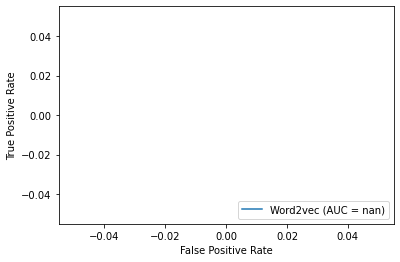

In [67]:
#roc curve
import matplotlib.pyplot as plt
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, prevs_prob)

roc_auc = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, estimator_name = 'Word2vec')
display.plot()
plt.show()

C:\Users\BeatrizCarvalho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\BeatrizCarvalho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


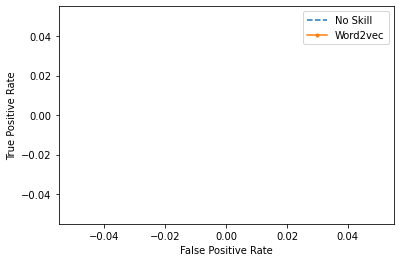

In [69]:
#roc curve
from sklearn.metrics import roc_curve
from matplotlib import pyplot

#generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test[:1000]))]

#predict probabilities
#prevs = prevs[:, 1]

#roc curve
ns_fpr, ns_tpr, _ = roc_curve(y_test[:1000], ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test[:1000], prevs_prob[:1000])

#plot
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Word2vec')

#axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

#legend
pyplot.legend()

#save
#plt.savefig(r'C:/Users/BeatrizCarvalho/Music/transfers/roc.png')

pyplot.show()

In [64]:
#---------------------------------------------------density matrix------------------------------------------------------------#

#product of the matrices

#weight matrices
m1 = model.wv.vectors
m2 = model.syn1neg  #negative sampling
#m2 = model.syn1    #hierarchical-softmax 

mproduct = np.matmul(m1, m2.T)
mproduct.shape

(21938, 21938)

In [65]:
#apply softmax to obtain a matrix with conditional probabilities
conditional_probs = softmax(mproduct)

In [78]:
#visualize the 1st 20 lines and the last 20 lines of the density matrix

#1st 20 lines
conditional_aux = conditional_probs[:20].copy()

#last 20 lines
conditional_aux = np.concatenate((conditional_aux, conditional_probs[-20:].copy()))

In [79]:
#save density matrix - after the product and the softmax
pd.DataFrame(conditional_aux).to_csv(r'C:/Users/BeatrizCarvalho/Music/transfers/density_matrix.csv', header = None, index = False)

In [81]:
#-------------------------------------------------eigenvalues-----------------------------------------------------------------#

#singular eingenvalues of the square matrix - after the product and before softmax - w has the eigenvalues and v the eigenvectors
w, v = np.linalg.eig(mproduct)  #mproduct is an array of arrays

#separate real and imaginary parts of the singular eigenvalues
x = w.real  #array

y = w.imag  #array

In [82]:
#save eigenvalues in csv
df = pd.DataFrame({"Real" : x, "Imaginary" : y})

df.to_csv(r'C:/Users/BeatrizCarvalho/Music/transfers/eigenvalues.csv', index = False)